In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import random
import csv
import math
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import seaborn as sns
from scipy.stats import wilcoxon
from scipy.spatial import ConvexHull
import pickle
import cv2
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from skimage.measure import regionprops_table
from skimage.measure import label as label_skimage
from scipy.stats import mannwhitneyu

In [2]:
shape_dict = {0: "blob", 1: "limbed", 2: "elongated", 3: "other"}
behavior_dict = {0: "jumping", 1: "walking", 2: "rolling", 3: "other"}

In [3]:
def get_elongation(row):
    return regionprops_table(label_skimage(process_static_posture_pretty(row)), properties=("centroid", "orientation", "eccentricity"))["eccentricity"]

In [4]:
def get_eccentricity(row, eps=1e-15):
    shape = process_static_posture_pretty(row)
    coords = []
    for x in range(shape.shape[0]):
        for y in range(shape.shape[1]):
            if shape[x, y] == 1:
                coords.append((x, y))
    points = np.array([[x, y] for x, y in coords])
    try:
        hull = ConvexHull(points)
    except:
        return 1.0
    polygon = Polygon(points[hull.vertices])
    hull_mask = np.zeros(shape.shape)
    for x in range(shape.shape[0]):
        for y in range(shape.shape[1]):
            if Point(x, y).distance(polygon) < eps:
                hull_mask[x, y] = 1
    return np.sum(shape) / np.sum(hull_mask)

In [5]:
def process_static_posture(row):
    try:
        string = row["shape.static"].split("/")
    except:
        string = row["shape.static"].item().split("/")
    out = np.zeros((len(string), len(string[0])))
    for r in range(out.shape[0]):
        for c in range(out.shape[1]):
            out[r][c] = int(string[r][c])
    return out

In [6]:
def process_static_posture_pretty(row):
    static = process_static_posture(row)
    to_add_x = (10 - static.shape[0]) // 2
    to_add_y = (10 - static.shape[1]) // 2
    out = np.zeros((10, 10))
    for r in range(static.shape[0]):
        for c in range(static.shape[1]):
            if static[r, c]:
                out[to_add_x + r, to_add_y + c] = 1
    return out

In [7]:
def process_dynamic_posture(row):
    out = np.zeros((16, 16))
    try:
        s = row["shape.dynamic"].split("|")
    except:
        s = row["shape.dynamic"].item().split("|")
    for r in range(len(s)):
        for c in range(len(s[r])):
            if s[r][c] == "█" or s[r][c] == "+":
                out[r, c] = 1
    return out

In [8]:
def parse_compressed_spectrum(row):
    out = np.zeros(100)
    curr = ""
    num = 0
    try:
        sequence = row["compressed.frequency"].item()
    except:
        sequence = row["compressed.frequency"]
    for n in sequence.split("-"):
        if "E" in n:
            curr += n.replace("E", "e-")
        else:
            curr += n
            out[num] = float(curr)
            curr = ""
            num += 1
    return out

In [81]:
data_vlow = pd.read_csv("/Users/federicopigozzi/Desktop/PhD/co-evolution_GECCO_21/VSRBiodiversity/dataset_vlow.csv", sep=";") 
data_vlow["folder"] = "dataset_vlow"
data_vhigh = pd.read_csv("/Users/federicopigozzi/Desktop/PhD/co-evolution_GECCO_21/VSRBiodiversity/dataset_vhigh.csv", sep=";")
data_vhigh["folder"] = "dataset_vhigh"
data = pd.concat([data_vlow, data_vhigh], axis=0)
data["id"] = data.index.values

In [9]:
def get_id(row):
    return int(row["filename"].split(".")[-2].split("-")[-1])

def set_behavior_label(row):
    if row["folder"] == "dataset_vlow":
        return "other"
    return row["behavior label"]

def fill_label(labels, row, label):
    label2num = {"blob": 0, "limbed": 1, "elongated": 2, "other": 3, "jumping": 0, "walking": 1, "rolling": 2}
    temp = labels[(labels["folder"] == row["folder"]) & (labels["id"] == row["id"]) & (labels["terrain"] == row["terrain"])]
    if not len(temp):
        return -1
    return label2num[temp[label].item().strip()]

In [10]:
labels = pd.read_csv("/Users/federicopigozzi/Downloads/Labels.csv", encoding='ISO-8859-1')
labels.dropna(axis=0, subset=["shape label", "behavior label"], how ="all", inplace=True)
labels["behavior label"] = labels.apply(lambda row: set_behavior_label(row), axis=1)
labels["id"] = labels.apply(lambda row: get_id(row), axis=1)
labels["terrain"] = labels.apply(lambda row: row["filename"].split(".")[0].lower(), axis=1)
labels.drop(["Unnamed: 6", "notes", "labeler"], inplace=True, axis=1)

In [124]:
data["shape"] = data.apply(lambda row: fill_label(labels, row, "shape label"), axis=1)

In [128]:
data["behavior"] = data.apply(lambda row: fill_label(labels, row, "behavior label"), axis=1)

In [139]:
data[data["shape"] != -1].to_csv("./data_and_labels.csv", sep=";", columns=["shape.static", "shape.dynamic", "compressed.frequency", "shape", "behavior"])

In [9]:
shape_clf = pickle.load(open("models/shape_classifier.sav", "rb"))
gait_clf = pickle.load(open("models/gait_classifier.sav", "rb"))

In [11]:
labeled_data = pd.read_csv("./data_and_labels.csv", sep=";")
labeled_data["all.label"] = labeled_data.apply(lambda row: row["behavior"] + row["shape"] * 4, axis=1)

In [15]:
pd.crosstab(labeled_data["shape"], labeled_data["behavior"], margins=True)

behavior,0,1,2,3,All
shape,,,,,
0,0,1,291,25,317
1,67,82,64,175,388
2,8,48,0,50,106
3,82,93,132,437,744
All,157,224,487,687,1555


In [9]:
x = np.array([process_dynamic_posture(row).flatten() for _, row in labeled_data.iterrows()])
y = labeled_data["shape"].values
shape_clf = None
best = float("-inf")
accs = []
for seed in range(20):
    for train, test in KFold(5).split(x):
        clf = RandomForestClassifier(random_state=seed, n_jobs=-1)
        clf.fit(x[train], y[train])
        acc = accuracy_score(clf.predict(x[test]), y[test])
        if acc > best:
            best = acc
            shape_clf = clf
        accs.append(acc)
print("mean accuracy over 5-fold: ", np.mean(accs))
print("best: ", best)

mean accuracy over 5-fold:  0.5948874598070739
best:  0.8327974276527331


In [10]:
x = np.array([parse_compressed_spectrum(row) for _, row in labeled_data.iterrows()])
y = labeled_data["behavior"].values
gait_clf = None
best = float("-inf")
accs = []
for seed in range(20):
    for train, test in KFold(5).split(x):
        clf = RandomForestClassifier(random_state=seed, n_jobs=-1)
        clf.fit(x[train], y[train])
        acc = accuracy_score(clf.predict(x[test]), y[test])
        if acc > best:
            best = acc
            gait_clf = clf
        accs.append(acc)
print("mean accuracy over 5-fold: ", np.mean(accs))
print("best: ", best)

mean accuracy over 5-fold:  0.8029581993569134
best:  0.8906752411575563


In [35]:
import pickle

pickle.dump(shape_clf, open("models/shape_classifier.sav", "wb"))
pickle.dump(gait_clf, open("models/gait_classifier.sav", "wb"))

In [10]:
# dataframe with the best individuals of each iteration of each run
save_serialized = False
best_cols = ["iterations", "births", "evolver", "controller", "morphology", "run", "terrain", "velocity", "shape.dynamic", "compressed.frequency", "shape.label", "behaviour.label", "all.label"]
everybody_cols = ["iterations", "births", "evolver", "controller", "morphology", "run", "terrain", "velocity", "num.voxels", "w", "h", "elongation", "eccentricity", "shape.static", "shape.dynamic", "compressed.frequency",
                              "shape.label", "behaviour.label", "all.label", "shape.diversity", "behaviour.diversity", "all.diversity", "is_last"]
if save_serialized:
    everybody_cols.append("serialized")
bests = pd.DataFrame(columns=best_cols)

# dataframe with all the individuals of the last iteration of each run
everybody = pd.DataFrame(columns=everybody_cols)

In [11]:
def compute_simpson_index(data, col):
    return 1.0 / np.sum((data[col].value_counts() / data.shape[0]) ** 2)

In [12]:
spectrum_cols = ["best→fitness→as[Outcome]→center.spectrum.y→[" + str(num) + "]" for num in range(100)]
path = "./output/"
for file in os.listdir(path):
    if file == ".DS_Store" or "cmaes" in file or not os.path.isfile(os.path.join(path, file)):
        continue
    print(file)
    traj = pd.read_csv(os.path.join(path, file), sep=";")
    traj = traj.rename({"event→iterations": "iterations",
                            "event→births": "births",
                            "individual→fitness→fitness": "best→fitness→as[Outcome]→distance",
                            "fitness→as[Outcome]→distance": "best→fitness→as[Outcome]→distance",
                            "solution→shape→num.voxel": "num.voxels",
                            "individual→solution→shape→num.voxel": "num.voxels",
                            "best→fitness→as[Outcome]→shape.dynamic": "shape.dynamic",
                            "fitness→as[Outcome]→shape.dynamic": "shape.dynamic",
                            "individual→solution→shape→w": "w",
                            "individual→solution→shape→h": "h",
                            "solution→shape→w": "w",
                            "solution→shape→h": "h",
                            "individual→solution→shape.static": "shape.static",
                            "solution→shape.static": "shape.static",
                            "individual→solution→serialized": "serialized",
                            "solution→serialized": "serialized"}, axis=1)
    traj = traj[traj.iterations != "iterations"]
    evolver = file.split(".")[0]
    traj["evolver"] = evolver
    representation = file.split(".")[2]
    controller = representation if "-" not in representation else representation.split("-")[1]
    traj["controller"] = controller
    traj["morphology"] = "direct" if "-" not in representation else representation.split("-")[0]
    traj["run"] = int(file.split(".")[1])
    terrain = file.split(".")[-3] if "all" in file else file.split(".")[-2]
    traj["terrain"] = terrain
    if controller != "homogeneous" or (evolver != "se-shape" and evolver != "ga"):
        continue
    try:
        traj["iterations"] = traj["iterations"].astype(np.int32)
    except:
        print(file.upper(), "FAILURE")
        continue
    traj["velocity"] = traj.apply(lambda row: float(row["best→fitness→as[Outcome]→distance"]) / 30.0, axis=1)
    special = "births" not in traj.columns
    if not special:
        traj["births"] = traj["births"].astype(np.int32)
    else:
        traj["births"] = traj["iterations"].apply(lambda elem: elem * 40)
    if "all" not in file or special:
        traj = traj.rename({"→".join(spectrum_cols[num].split("→")[1:]): spectrum_cols[num] for num in range(len(spectrum_cols))}, axis=1)
        traj["compressed.frequency"] = traj.apply(lambda row: "-".join(row[spectrum_cols].astype(str)), axis=1)
    traj["shape.label"] = shape_clf.predict(np.array([process_dynamic_posture(row).flatten() for _, row in traj.iterrows()]))
    traj["behaviour.label"] = gait_clf.predict(np.array([parse_compressed_spectrum(row).flatten() for _, row in traj.iterrows()]))
    traj["all.label"] = traj.apply(lambda row: row["behaviour.label"] + row["shape.label"] * 4, axis=1)
    if "all" in file:
        last_it = traj["iterations"].max()
        for it, t in traj.groupby(["iterations"]):
            t["shape.diversity"] = compute_simpson_index(t, "shape.label")
            t["behaviour.diversity"] = compute_simpson_index(t, "behaviour.label")
            t["all.diversity"] = compute_simpson_index(t, "all.label")
            t["is_last"] = 0 if it != last_it else 1
            t["elongation"] = t.apply(lambda row: get_elongation(row), axis=1)
            t["eccentricity"] = t.apply(lambda row: get_eccentricity(row), axis=1)
            everybody = everybody.append(t[everybody_cols])
    else:
        bests = bests.append(traj[best_cols])

se-shape.3.homogeneous.10x10.vel-area-touch.1.downhill-30.all.csv
se-behaviour.2.heterogeneous.10x10.vel-area-touch.1.flat.csv
ga.5.heterogeneous.10x10.vel-area-touch.1.flat.all.csv
se-shape.1.homogeneous.10x10.vel-area-touch.1.uphill-20.csv
ga.0.homogeneous.10x10.vel-area-touch.1.uphill-20.csv
ga.8.homogeneous.10x10.vel-area-touch.1.downhill-30.csv
es.2.heterogeneous.10x10.vel-area-touch.1.flat.csv
se-geno.8.homogeneous.10x10.vel-area-touch.1.flat.csv
se-shape.2.heterogeneous.10x10.vel-area-touch.1.flat.all.csv
ga.7.heterogeneous.10x10.vel-area-touch.1.flat.csv
se-behaviour.7.homogeneous.10x10.vel-area-touch.1.flat.csv
se-shape.3.heterogeneous.10x10.vel-area-touch.1.flat.csv
se-behaviour.8.homogeneous.10x10.vel-area-touch.1.flat.all.csv
ga.1.homogeneous.10x10.vel-area-touch.1.downhill-30.csv
se-shape.4.homogeneous.10x10.vel-area-touch.1.flat.all.csv
ga.2.homogeneous.10x10.vel-area-touch.1.uphill-20.csv
se-shape.3.heterogeneous.10x10.vel-area-touch.1.flat.all.csv
se-shape.4.homogeneous

se-geno.6.heterogeneous.10x10.vel-area-touch.1.flat.all.csv
se-shape.1.homogeneous.10x10.vel-area-touch.1.downhill-30.all.csv
ga.9.homogeneous.10x10.vel-area-touch.1.downhill-30.csv
ga.1.homogeneous.10x10.vel-area-touch.1.uphill-20.csv
se-shape.4.homogeneous.10x10.vel-area-touch.1.flat.csv
ga.3.homogeneous.10x10.vel-area-touch.1.flat.all.csv
se-shape.0.homogeneous.10x10.vel-area-touch.1.uphill-20.csv
se-geno.4.heterogeneous.10x10.vel-area-touch.1.flat.csv
se-behaviour.5.homogeneous.10x10.vel-area-touch.1.flat.all.csv
se-geno.7.heterogeneous.10x10.vel-area-touch.1.flat.all.csv
se-shape.9.homogeneous.10x10.vel-area-touch.1.flat.all.csv
se-shape.1.homogeneous.10x10.vel-area-touch.1.flat.csv
se-shape.6.homogeneous.10x10.vel-area-touch.1.uphill-20.all.csv
ga.5.homogeneous.10x10.vel-area-touch.1.downhill-30.all.csv
es.4.homogeneous.10x10.vel-area-touch.1.flat.all.csv
se-behaviour.6.heterogeneous.10x10.vel-area-touch.1.flat.csv
se-shape.2.homogeneous.10x10.vel-area-touch.1.uphill-20.csv
es.7.

In [77]:
for label, traj in everybody.groupby(["evolver", "controller", "morphology", "run", "terrain"]):
    traj = traj[traj["iterations"] == traj["iterations"].max()]
    print(label, traj["all.diversity"].median())

('es', 'heterogeneous', 'direct', 0, 'flat') 1.9851116625310172
('es', 'heterogeneous', 'direct', 1, 'flat') 1.0512483574244416
('es', 'heterogeneous', 'direct', 2, 'flat') 1.3628620102214652
('es', 'heterogeneous', 'direct', 3, 'flat') 1.0
('es', 'heterogeneous', 'direct', 4, 'flat') 1.0
('es', 'heterogeneous', 'direct', 5, 'flat') 1.0
('es', 'heterogeneous', 'direct', 6, 'flat') 1.5122873345935726
('es', 'heterogeneous', 'direct', 7, 'flat') 1.1049723756906078
('es', 'heterogeneous', 'direct', 8, 'flat') 1.9950124688279303
('es', 'heterogeneous', 'direct', 9, 'flat') 2.0997375328083994
('es', 'homogeneous', 'direct', 0, 'flat') 1.822323462414579
('es', 'homogeneous', 'direct', 1, 'flat') 1.454545454545455
('es', 'homogeneous', 'direct', 2, 'flat') 1.9950124688279303
('es', 'homogeneous', 'direct', 3, 'flat') 1.3628620102214652
('es', 'homogeneous', 'direct', 4, 'flat') 1.0
('es', 'homogeneous', 'direct', 5, 'flat') 1.0
('es', 'homogeneous', 'direct', 6, 'flat') 4.102564102564103
('es

In [12]:
def plot_fitness(data):
    for label, traj in data.groupby(["evolver", "controller"]):
        x = []
        for it, t in traj.groupby(["iterations"]):
            x.append(t["births"].median())
        median = traj.groupby(traj.iterations)["velocity"].median()
        err = traj.groupby(traj.iterations)["velocity"].std()
        plt.plot(x, median, linestyle="dashed" if label[1] == "heterogeneous" else "solid", label="-".join(label))
    plt.xlabel("births")
    plt.ylabel("velocity")
    plt.legend(bbox_to_anchor=(1.05, 1))

In [13]:
def plot_fitness_boxplot(data, by="morphology"):
    fig, ax = plt.subplots(figsize=(10,5), nrows=1, ncols=1)
    d = {}
    for label, traj in data.groupby(["evolver", by]):
        traj = traj[traj["iterations"] == traj["iterations"].max()]
        d[label[0] + "\n" + label[1]] = traj.groupby(traj.run)["velocity"].max()
    ax.boxplot(d.values())
    ax.set_xticklabels(d.keys())
    ax.set_ylabel("velocity")
    return d

In [14]:
def plot_col_by_terrain(data, col, title):
    colour_map = {"downhill-20": "limegreen", "downhill-25": "forestgreen", "downhill-30": "darkgreen", 
                  "uphill-20": "lightcoral", "uphill-25": "brown", "uphill-30": "darkred"}
    for label, traj in data.groupby(["terrain", "evolver"]):
        x = []
        for it, t in traj.groupby(["iterations"]):
            x.append(t["births"].median())
        plt.plot(x, traj.groupby(traj.iterations)[col].median(), 
                 linestyle="dashed" if label[1] == "se-shape" else "solid", color=colour_map[label[0]], label=" ".join(label))
    plt.xlabel("births")
    plt.ylabel(title)
    plt.legend(bbox_to_anchor=(1.05, 1))

In [15]:
def plot_simpson_index(data):
    for label, traj in data.groupby(["evolver", "controller"]):
        x = []
        for it, t in traj.groupby(["iterations"]):
            x.append(t["births"].median())
        median = traj.groupby(traj.iterations)["all.diversity"].median()
        err = traj.groupby(traj.iterations)["all.diversity"].std()
        plt.plot(x, median, linestyle="dashed" if label[1] == "heterogeneous" else "solid", label="-".join(label))
        #plt.fill_between(x, median - err, median + err, alpha=0.15)
    plt.xlabel("births")
    plt.ylabel("ISI")
    plt.legend(bbox_to_anchor=(1.05, 1))

In [16]:
def plot_simpson_index_boxplot(data, by="morphology"):
    fig, ax = plt.subplots(figsize=(10,5), nrows=1, ncols=1)
    d = {}
    for label, traj in data.groupby(["evolver", by]):
        traj = traj[traj["iterations"] == traj["iterations"].max()]
        d[label[0] + "\n" + label[1]] = traj.groupby(traj.run)["all.diversity"].median()
    ax.boxplot(d.values())
    ax.set_xticklabels(d.keys())
    ax.set_ylabel("ISI")
    return d

In [17]:
def plot_last_iteration_metrics(data):
    fig, axes = plt.subplots(figsize=(20, 5), nrows=1, ncols=2)
    num = 0
    labels = {"velocity": "fitness", "all.diversity": "Overall div."}
    evolvers = data["evolver"].unique().tolist()
    controllers = data["controller"].unique().tolist()
    for label in labels:
        dat = np.zeros((len(data["evolver"].unique()), len(data["controller"].unique())))
        for (e, c), d in data.groupby(["evolver", "controller"]):
            d = d[d["iterations"] == d["iterations"].max()]
            x = []
            for _, r in d.groupby(["run"]):
                x.append(r[r["velocity"] == r["velocity"].max()].sample(1)[label].item())
            dat[evolvers.index(e), controllers.index(c)] = np.median(x)
        sns.heatmap(dat, annot=True, ax=axes[num], yticklabels=evolvers,
                xticklabels=controllers, cmap=sns.cubehelix_palette(as_cmap=True))
        axes[num].set_title(labels[label])
        num += 1

In [30]:
def plot_last_iteration_species(data):
    fig, axes = plt.subplots(figsize=(20, 5), nrows=1, ncols=2)
    label_to_shape = {0: "blob", 1: "limbed", 2: "elongated", 3: "other"}
    label_to_gait = {0: "jumping", 1: "walking", 2: "rolling", 3: "other"}
    
    dat_fit = np.zeros((len(label_to_gait), len(label_to_shape)))
    for (e, c), d in data.groupby(["behaviour.label", "shape.label"]):
        x = []
        for _, exp in d.groupby(["evolver", "controller", "run", "morphology", "terrain"]):
            exp = exp[exp["iterations"] == exp["iterations"].max()]
            x.extend(exp["velocity"].tolist())
        dat_fit[list(label_to_gait.keys()).index(e), list(label_to_shape.keys()).index(c)] = np.median(x)
    sns.heatmap(dat_fit, annot=True, ax=axes[0], yticklabels=list(label_to_gait.values()),
            xticklabels=list(label_to_shape.values()), cmap=sns.cubehelix_palette(as_cmap=True))
    axes[0].set_title("fitness")
    
    dat_rate = np.zeros((len(label_to_gait), len(label_to_shape)))
    for (e, c), d in data.groupby(["behaviour.label", "shape.label"]):
        x = []
        for _, exp in d.groupby(["evolver", "controller", "run", "morphology", "terrain"]):
            exp = exp[exp["iterations"] == exp["iterations"].max()]
            x.append(len(exp) / 100)
        dat_rate[list(label_to_gait.keys()).index(e), list(label_to_shape.keys()).index(c)] = np.median(x)
    sns.heatmap(dat_rate, annot=True, ax=axes[1], yticklabels=list(label_to_gait.values()),
            xticklabels=list(label_to_shape.values()), cmap=sns.cubehelix_palette(as_cmap=True))
    axes[1].set_title("number of VSRs")
    return dat_fit, dat_rate

In [19]:
def plot_scatterplot(data):
    colour_map = {"es": "green", "ga": "red", "se-geno": "blue", "se-shape": "purple", "se-behaviour": "pink"}
    for label, traj in data.groupby(["evolver", "controller"]):
        traj = traj[traj["iterations"] == traj["iterations"].max()]
        plt.scatter(traj["velocity"].median(),  traj["all.diversity"].median(),
                 marker="^" if label[1] == "heterogeneous" else "o", color=colour_map[label[0]], label="-".join(label))
    plt.xlabel("velocity")
    plt.ylabel("ISI")
    plt.legend(bbox_to_anchor=(1.05, 1))

In [41]:
def plot_species_map(bests, everybody, spectrum_size=100):
    marker_map = {"flat": "o", "downhill-30": "^", "uphill-20": "x"}
    lasts = everybody[everybody["is_last"] == 1]
    best_X = np.array([np.concatenate([parse_compressed_spectrum(best), process_dynamic_posture(best).flatten()]) for _, best in bests.iterrows()])
    last_X = np.array([np.concatenate([parse_compressed_spectrum(best), process_dynamic_posture(best).flatten()]) for _, best in everybody[everybody["is_last"] == 1].iterrows()])

    best_Xs = [best_X[:, spectrum_size:], best_X[:, :spectrum_size], best_X]
    last_Xs = [last_X[:, spectrum_size:],last_X[:, :spectrum_size], last_X]

    best_pcas = [PCA(n_components=2).fit(x) for x in best_Xs]
    last_pcas = [PCA(n_components=2).fit(x) for x in last_Xs]

    best_Ys = [np.array([best["shape.label"] for _, best in bests.iterrows()]),
         np.array([best["behaviour.label"] for _, best in bests.iterrows()]),
         np.array([best["all.label"] for _, best in bests.iterrows()])]
    last_Ys = [np.array([best["shape.label"] for _, best in lasts.iterrows()]),
         np.array([best["behaviour.label"] for _, best in lasts.iterrows()]),
         np.array([best["all.label"] for _, best in lasts.iterrows()])]

    fig, axes = plt.subplots(figsize=(20, 5), nrows=1, ncols=3)
    titles = ["Shape", "Behaviour", "Overall"]

    bests["old_index"] = bests.index.copy()
    candidates = bests.groupby(["evolver", "run"]).apply(lambda x: x[x["iterations"] == x["iterations"].max()]).set_index("old_index")
    print(candidates.shape)
    for num in range(3):
        pca = last_pcas[num]
        #knn = KNeighborsClassifier()
        #X_new = pca.transform(last_Xs[num])

        #x_min, x_max = X_new[:, 0].min() - 1, X_new[:, 0].max() + 1
        #y_min, y_max = X_new[:, 1].min() - 1, X_new[:, 1].max() + 1
        #xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05),
        #                     np.arange(y_min, y_max, 0.05))

        # here "model" is your model's prediction (classification) function
        #knn.fit(X_new, last_Ys[num].ravel())
        #Z = knn.predict(np.c_[xx.ravel(), yy.ravel()]) 

        # Put the result into a color plot
        #Z = Z.reshape(xx.shape)
        #axes[num].contourf(xx, yy, Z, cmap="viridis", alpha=0.75)
        for terrain, traj in candidates.groupby(["terrain"]):
            features = np.array([np.concatenate([parse_compressed_spectrum(best), process_dynamic_posture(best).flatten()]) for _, best in traj.iterrows()])
            curr_x = [features[:, spectrum_size:], features[:, :spectrum_size], features]
            curr = pca.transform(curr_x[num])
            axes[num].scatter(curr[:, 0], curr[:, 1], cmap="Set1",
                              label=terrain, s=75, alpha=0.75, edgecolors="black", marker=marker_map[terrain])
            axes[num].set_xlabel("PC1")
            axes[num].set_ylabel("PC2")
            axes[num].set_title(titles[num])
            axes[num].legend()

In [189]:
def plot_species_pca(bests, everybody):
    out = pd.DataFrame(columns=["terrain", "label", "type", "PC1", "PC2"])
    fig, axes = plt.subplots(figsize=(15, 5), nrows=1, ncols=2)
    marker_map = {"flat": "o", "downhill-30": "^", "uphill-20": "x"}
    shape_color = {0: "red", 1: "blue", 2: "green", 3: "purple"}
    behavior_color = {0: "red", 1: "blue", 2: "green", 3: "purple"}
    everybody = everybody[everybody["is_last"] == 1].copy()
    shape_x = np.array([process_dynamic_posture(row).flatten() for _, row in everybody.iterrows()])
    behavior_x = np.array([parse_compressed_spectrum(row) for _, row in everybody.iterrows()])
    shape_x_norm = (shape_x - shape_x.mean()) / shape_x.std()
    pca_shape = PCA(n_components=2)
    pca_shape.fit(shape_x_norm)
    behavior_x_norm = (behavior_x - behavior_x.mean()) / behavior_x.std()
    pca_behavior = PCA(n_components=2)
    pca_behavior.fit(behavior_x_norm)
    for (ea, r, terrain), traj in bests.groupby(["evolver", "run", "terrain"]):
        traj = traj[traj["iterations"] == traj["iterations"].max()]
        for (shape, behavior), d in traj.groupby(["shape.label", "behaviour.label"]):
            shape_best = pca_shape.transform(np.array([process_dynamic_posture(row).flatten() for _, row in d.iterrows()]))
            behavior_best = pca_behavior.transform(np.array([parse_compressed_spectrum(row) for _, row in d.iterrows()]))
            axes[0].scatter(shape_best[:, 0], shape_best[:, 1], marker=marker_map[terrain], color=shape_color[shape])
            axes[1].scatter(behavior_best[:, 0], behavior_best[:, 1], marker=marker_map[terrain], color=behavior_color[behavior])
            out = out.append({"terrain": terrain, "type": "shape", "label": shape, "PC1": shape_best[:, 0].item(), "PC2": shape_best[:, 1].item()}, ignore_index=True)
            out = out.append({"terrain": terrain, "type": "behavior", "label": behavior, "PC1": behavior_best[:, 0].item(), "PC2": behavior_best[:, 1].item()}, ignore_index=True)
    for ax in axes:
        ax.set_xlabel("PC1", fontsize=10)
        ax.set_ylabel("PC2", fontsize=10)
    return out

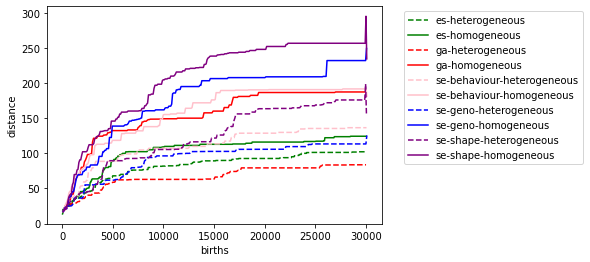

In [154]:
plot_fitness(bests[bests["terrain"] == "flat"])

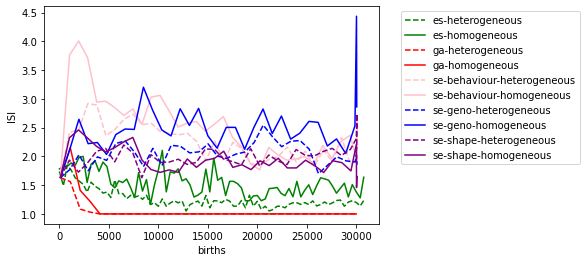

In [156]:
plot_simpson_index(everybody[everybody["terrain"] == "flat"])

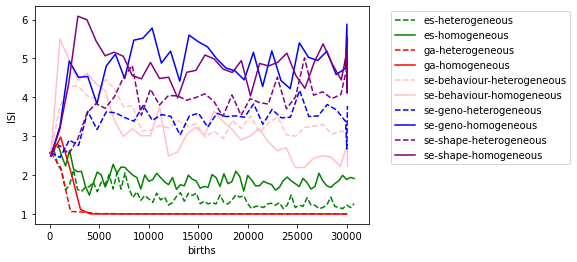

In [43]:
plot_simpson_index(everybody)

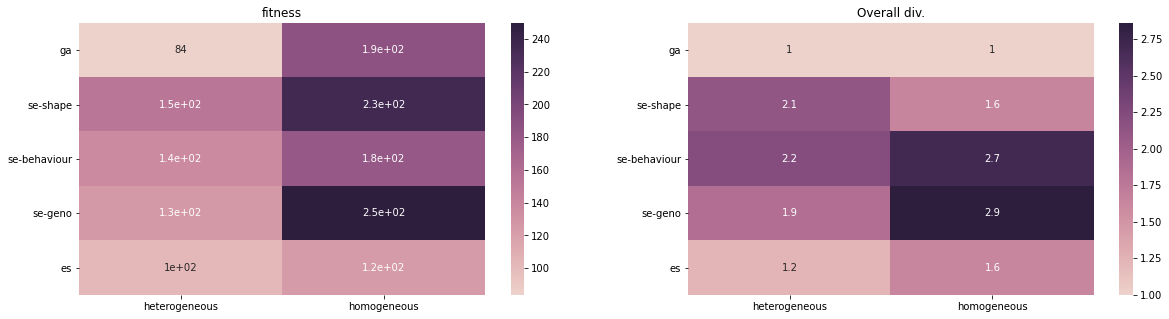

In [157]:
plot_last_iteration_metrics(everybody[everybody["terrain"] == "flat"])

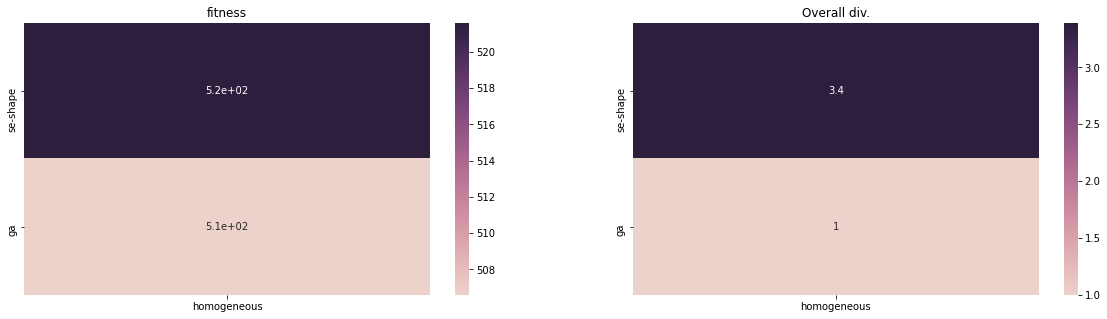

In [170]:
plot_last_iteration_metrics(everybody[everybody["terrain"] == "downhill-30"])

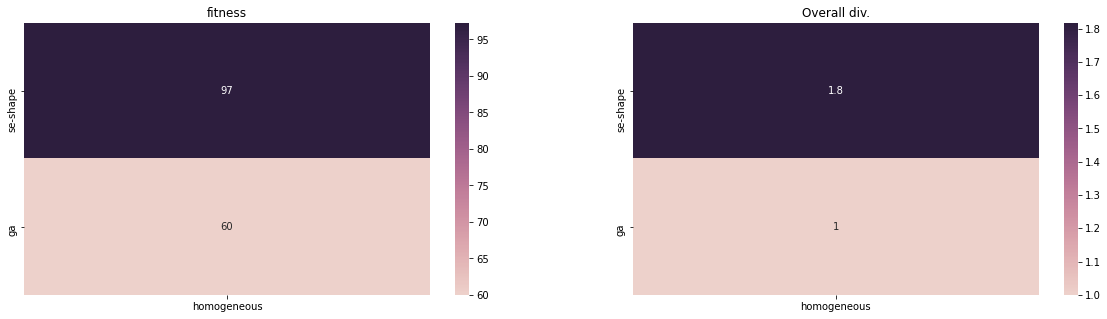

In [171]:
plot_last_iteration_metrics(everybody[everybody["terrain"] == "uphill-20"])

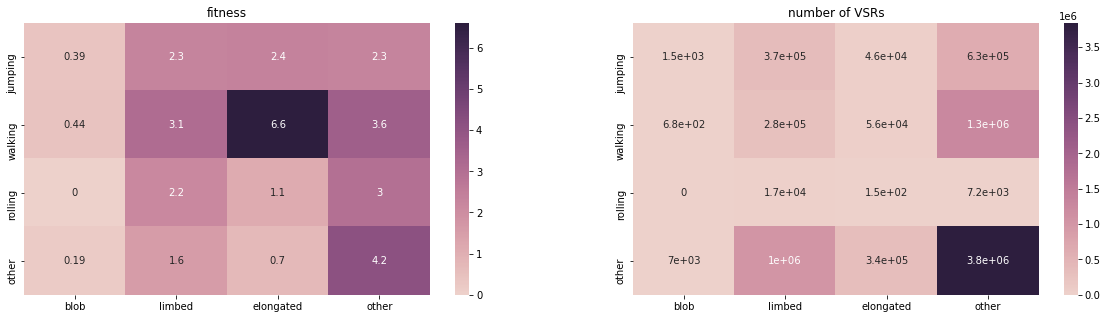

In [20]:
plot_last_iteration_species(everybody[(everybody["terrain"] == "flat")])

In [16]:
everybody[(everybody["terrain"] == "downhill-30") & ((everybody["evolver"] == "ga") | (everybody["evolver"] == "se-shape")) & (everybody["morphology"] == "direct")].shape

(65000, 23)

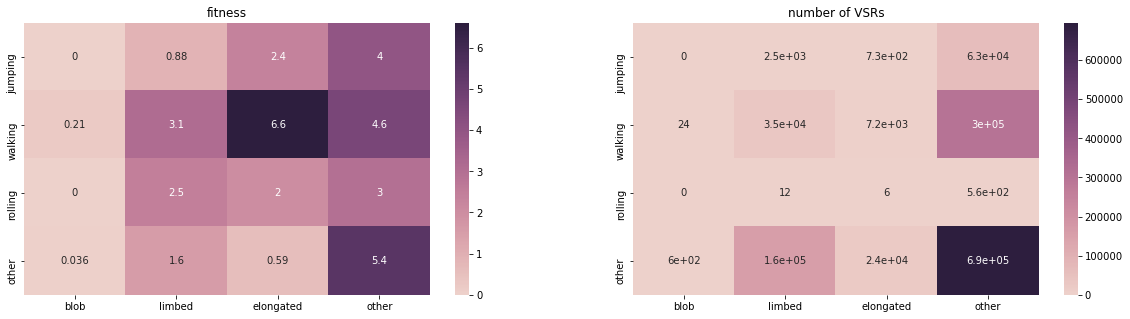

In [21]:
plot_last_iteration_species(everybody[(everybody["terrain"] == "flat") & ((everybody["evolver"] == "ga") | (everybody["evolver"] == "se-shape"))])

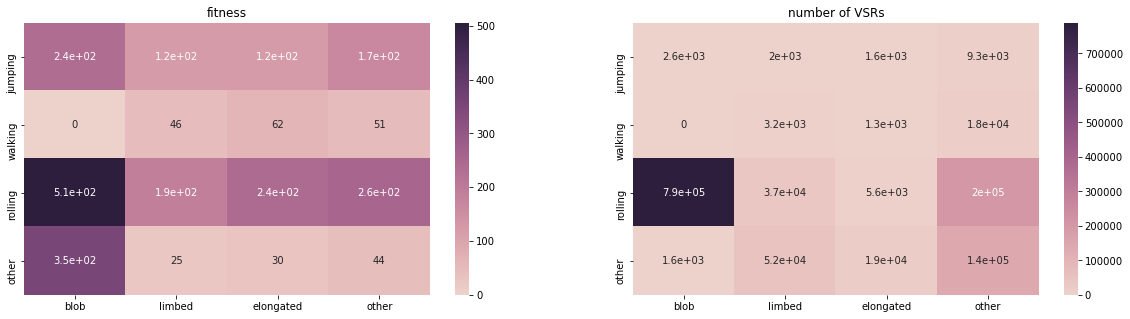

In [163]:
plot_last_iteration_species(everybody[everybody["terrain"] == "downhill-30"])

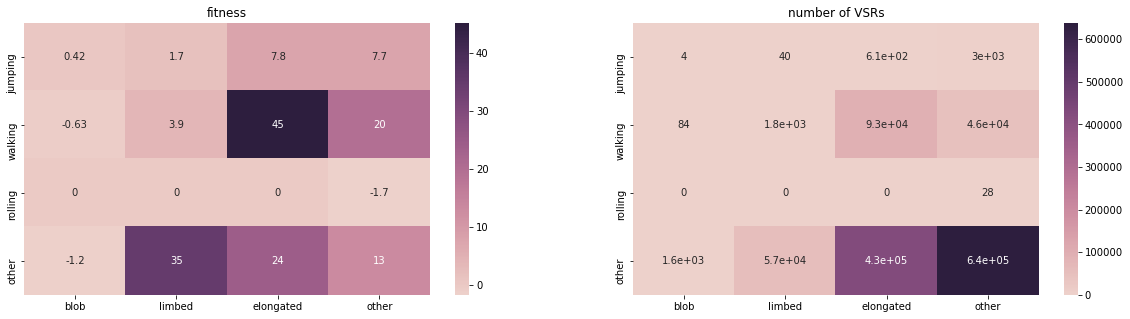

In [164]:
plot_last_iteration_species(everybody[everybody["terrain"] == "uphill-20"])

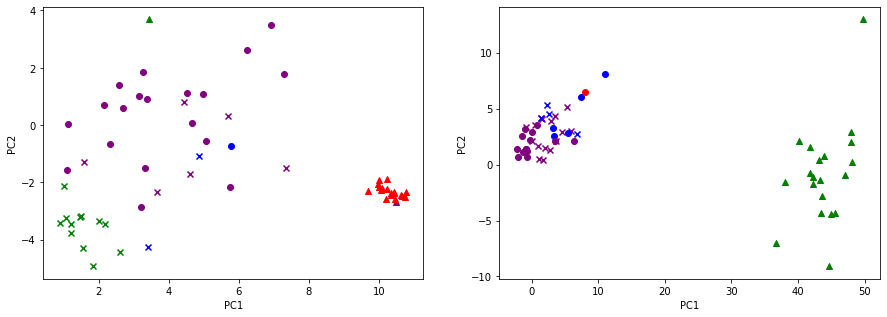

In [17]:
plot_species_pca(bests[(bests["morphology"] == "direct") & ((bests["evolver"] == "ga") | (bests["evolver"] == "se-shape")) & (bests["controller"] == "homogeneous")], everybody[(everybody["morphology"] == "direct") & ((everybody["evolver"] == "ga") | (everybody["evolver"] == "se-shape")) & (everybody["controller"] == "homogeneous")])

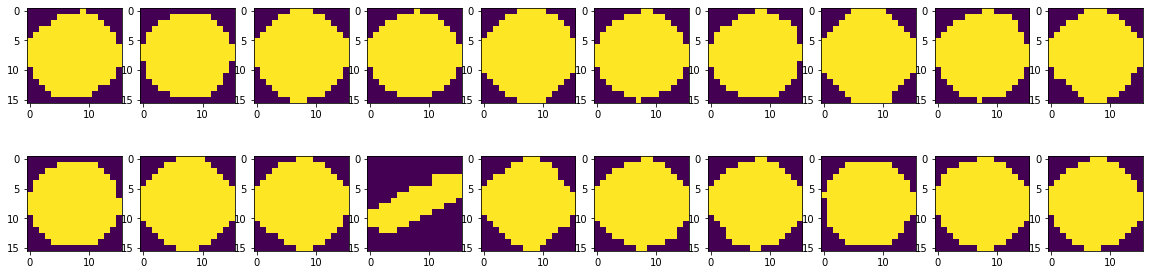

In [31]:
fig, axes = plt.subplots(figsize=(20, 5), nrows=2, ncols=10)

for (ev, run), traj in bests[bests["terrain"] == "downhill-30"].groupby(["evolver", "run"]):
    traj = traj[traj["iterations"] == traj["iterations"].max()]
    ax = axes[0][run] if ev == "ga" else axes[1][run]
    ax.imshow(process_dynamic_posture(traj))

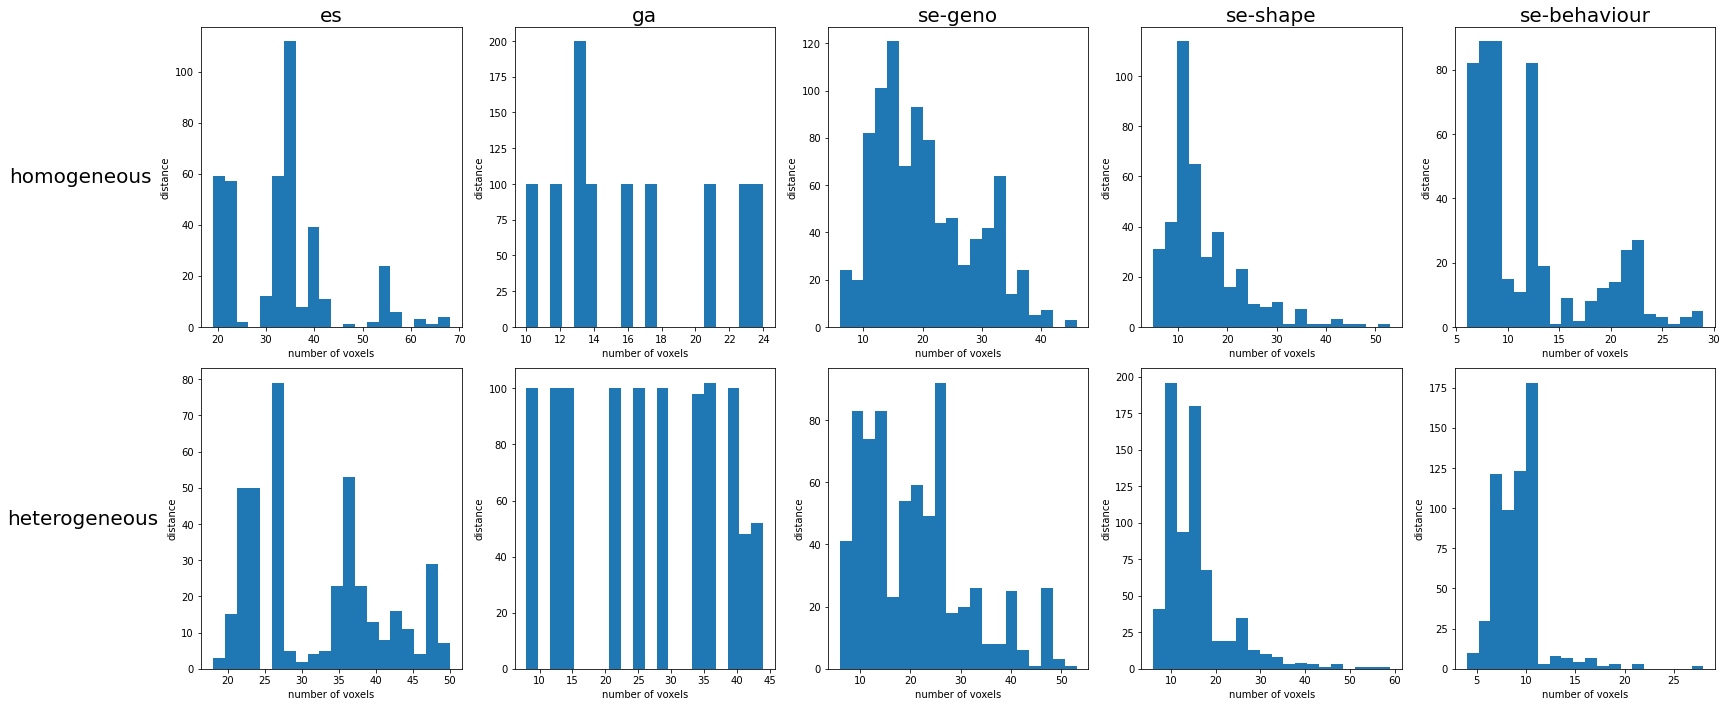

In [46]:
fig, axes = plt.subplots(figsize=(25, 10), nrows=2, ncols=5)
evolver_to_idx = {"es": 0, "ga": 1, "se-geno": 2, "se-shape": 3, "se-behaviour": 4}

num = 0
for (e, c), traj in everybody.groupby(["evolver", "controller"]):
    traj = traj[traj["iterations"] == traj["iterations"].max()]
    col = evolver_to_idx[e]
    row = 0 if c == "homogeneous" else 1
    axes[row][col].hist(traj["num.voxels"], bins=20)
    axes[row][col].set_xlabel("number of voxels", fontsize=10)
    axes[row][col].set_ylabel("velocity", fontsize=10)
    num += 1
    
pad = 5
for ax, col in zip(axes[0], list(evolver_to_idx.keys())):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size=20, ha='center', va='baseline')

for ax, row in zip(axes[:,0], ["homogeneous", "heterogeneous"]):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size=20, ha='right', va='center')
    
fig.tight_layout()
fig.subplots_adjust(left=0.15, top=0.95)

In [199]:
def plot_feature_hist_by_morphology(data, column, title):
    fig, axes = plt.subplots(figsize=(20, 5), nrows=2, ncols=2)
    num = 0
    upper = data[column].max()
    lower = data[column].min()
    out = pd.DataFrame(columns=["iteration", "morphology", "descriptor"])
    for morph, traj in data.groupby(["morphology"]):
        temp = traj[traj["iterations"] == 0]
        for _, row in temp.iterrows():
            out = out.append({"iteration": "first", "morphology": morph, "descriptor": row[column]}, ignore_index=True)
        axes[num][0].hist(temp[column], bins=20)
        temp = pd.DataFrame(columns=everybody.columns)
        for _, exp in traj.groupby(["evolver", "controller", "run", "terrain"]):
            temp = temp.append(exp[exp["iterations"] == exp["iterations"].max()])
        for _, row in temp.iterrows():
            out = out.append({"iteration": "last", "morphology": morph, "descriptor": row[column]}, ignore_index=True)
        axes[num][1].hist(temp[column], bins=20)
        axes[num][0].set_ylabel(morph, fontsize=15)
        axes[num][0].set_xlim(lower, upper)
        axes[num][1].set_xlim(lower, upper)
        num += 1

    axes[0][0].set_title("first iteration", fontsize=15)
    axes[0][1].set_title("last iteration", fontsize=15)
    
    fig.suptitle(title, fontsize=20)
    
    del temp
    return out

In [66]:
def plot_size_density(data):
    fig, axes = plt.subplots(figsize=(20, 5), nrows=1, ncols=3)
    for terrain, traj in data.groupby(["terrain"]):
        sns.distplot(traj["num.voxels"], hist=False, kde=True, label=terrain, ax=axes[0])
        sns.distplot(traj[traj["iterations"] == 0]["num.voxels"], hist=False, kde=True, label=terrain, ax=axes[1])
        temp = pd.DataFrame(columns=traj.columns)
        for _, exp in traj.groupby(["evolver", "controller", "run"]):
            temp = temp.append(exp[exp["iterations"] == exp["iterations"].max()])
        sns.distplot(temp["num.voxels"], hist=False, kde=True, label=terrain, ax=axes[2])

    axes[0].set_title("all iterations", fontsize=15)
    axes[1].set_title("first iteration", fontsize=15)
    axes[2].set_title("last iteration", fontsize=15)

    for ax in axes:
        ax.set_xlim(5, 65)
        ax.set_xlabel("number of voxels", fontsize=15)
        ax.set_ylabel("occurences", fontsize=15)
        ax.legend()
    
    del temp

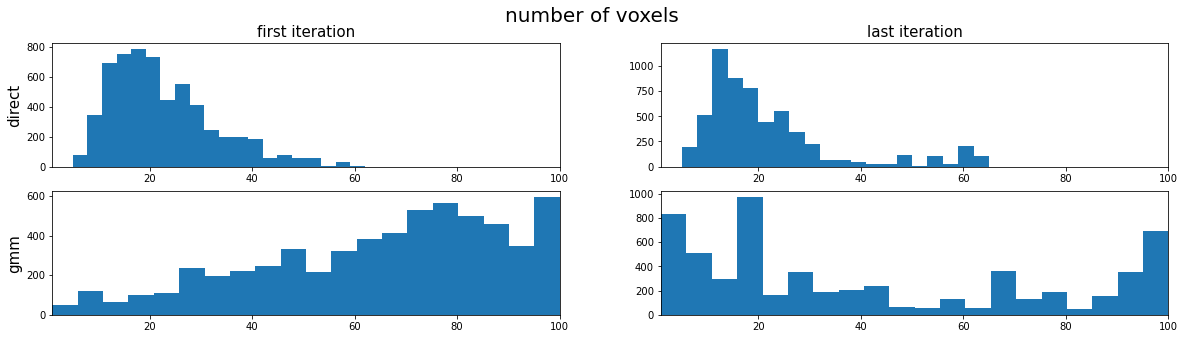

In [54]:
plot_feature_hist_by_morphology(everybody, "num.voxels", "number of voxels")

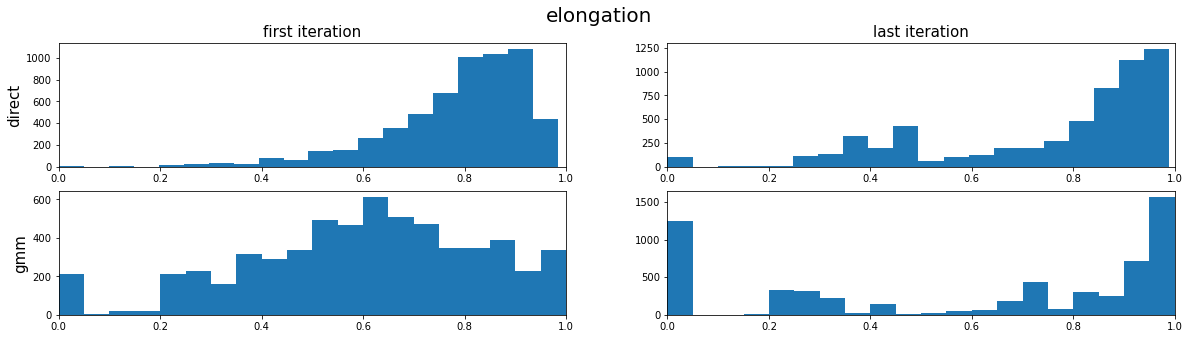

In [55]:
plot_feature_hist_by_morphology(everybody, "elongation", "elongation")

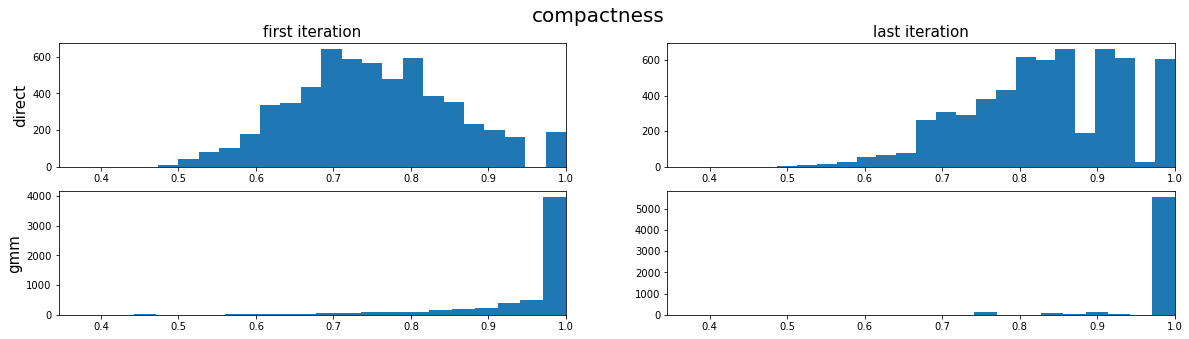

In [56]:
plot_feature_hist_by_morphology(everybody, "eccentricity", "compactness")

/Users/federicopigozzi/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/federicopigozzi/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/federicopigozzi/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `di

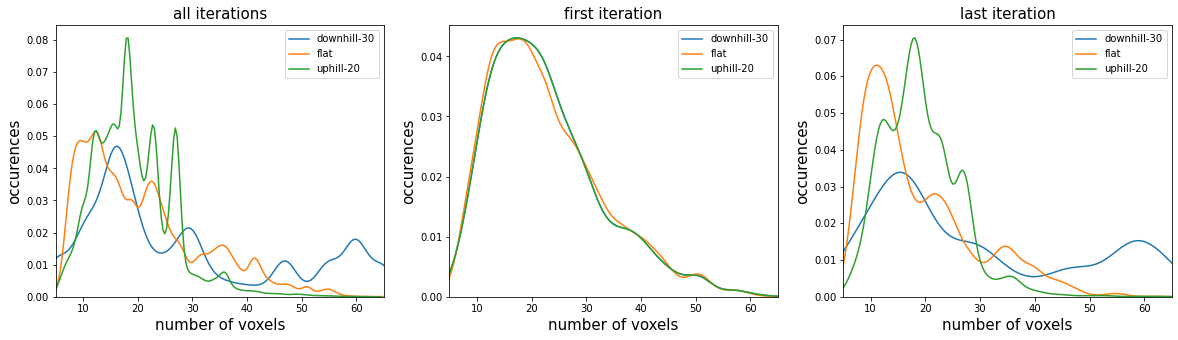

In [73]:
plot_size_density(everybody)

In [40]:
def plot_shape_features(data):
    fig, axes = plt.subplots(figsize=(20, 5), nrows=1, ncols=4)
    cols = ["num.voxels", "elongation", "eccentricity", "distance"]
    
    for num, col in enumerate(cols):
        axes[num].hist(data[col], bins=30)
        axes[num].set_ylabel("frequency")
            
    axes[0].set_xlabel("number of voxels")
    axes[1].set_xlabel("elongation")
    axes[2].set_xlabel("eccentricity")
    axes[3].set_xlabel("distance")
    
    fig.tight_layout()

In [ ]:
everybody["elongation"] = everybody.apply(lambda row: get_elongation(row)[0], axis=1)
everybody["eccentricity"] = everybody.apply(lambda row: get_eccentricity(row), axis=1)

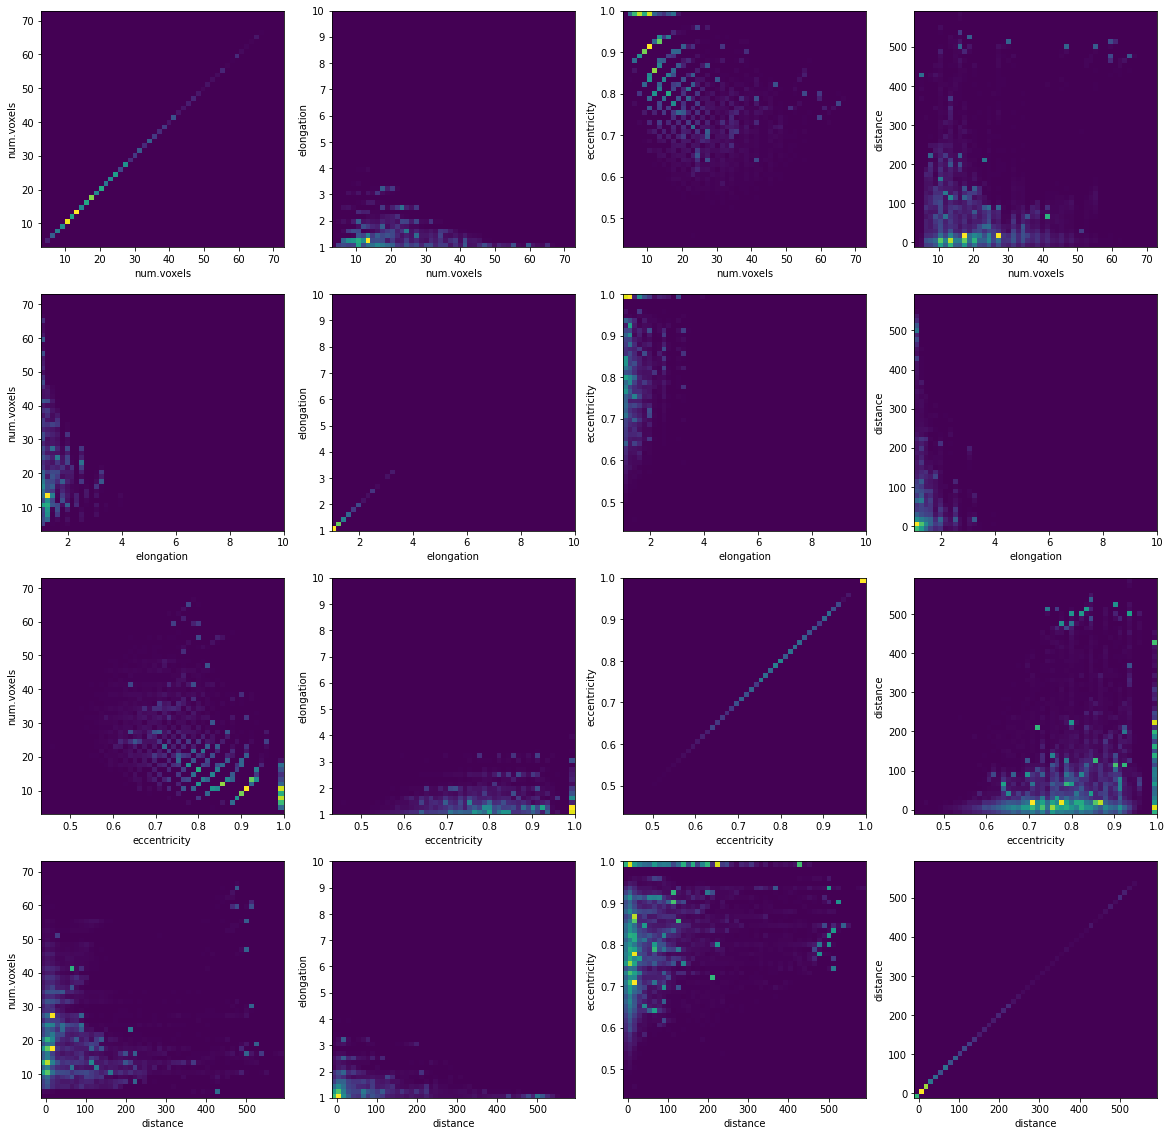

In [207]:
plot_shape_features(everybody)

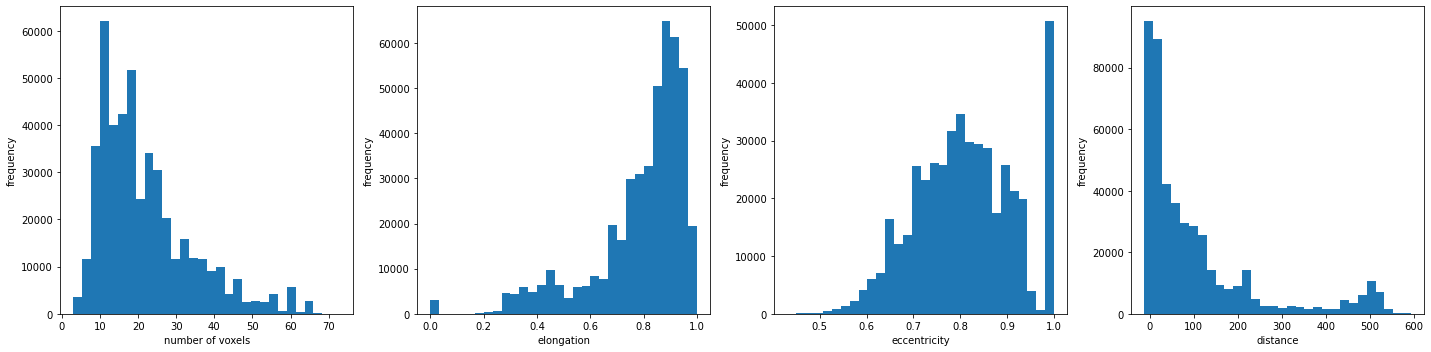

In [27]:
plot_shape_features(everybody)

In [35]:
def s(im, row):
    im[row["num.voxels.bins"], row["distance.bins"]] += 1#row["num.voxels.bins"] + row["eccentricity.bins"], row["elongation.bins"] + row["distance.bins"]] += 1

In [36]:
def create_labeled_dataset(data):
    data["num.voxels.bins"] = pd.qcut(data["num.voxels"], 4, labels=[0, 1, 2, 3])
    #data["elongation.bins"] = pd.qcut(data["elongation"], 4, labels=[0, 4, 8, 12])
    #data["eccentricity.bins"] = pd.qcut(data["eccentricity"], 4, labels=[0, 1, 2, 3])
    data["distance.bins"] = pd.qcut(data["distance"], 4, labels=[0, 1, 2, 3])
    return data

In [37]:
def plot_as_qd(data):
    im = np.zeros((4, 4))
    labels = create_labeled_dataset(data)
    labels.apply(lambda row: s(im, row), axis=1)
    plt.hlines([3.5, 7.5, 11.5], 0, 16, color="red")
    plt.vlines([3.5, 7.5, 11.5], 0, 16, color="red")
    plt.xticks([0, 4, 8, 12], ["eccentricity"] * 4, rotation=45)
    plt.yticks([2, 6, 10, 14], ["distance"] * 4)
    plt.xlabel("elongation")
    plt.ylabel("number of voxels")
    plt.imshow(im)
    plt.colorbar()

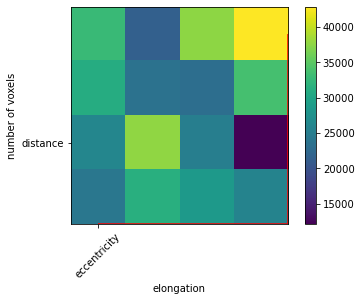

In [38]:
plot_as_qd(everybody)

In [109]:
sample_vlow = None
sample_vhigh = None

d = 60
v_low = 1
v_high = 35
for label, traj in everybody[everybody["distance"] < d].groupby(["num.voxels.bins", "elongation.bins", "eccentricity.bins"]):
    if sample_vlow is None:
        sample_vlow = pd.DataFrame(columns=traj.columns)
    sample_vlow = sample_vlow.append(traj.sample(min(v_low, len(traj))))
    
for label, traj in everybody[everybody["distance"] >= d].groupby(["num.voxels.bins", "elongation.bins", "eccentricity.bins"]):
    if sample_vhigh is None:
        sample_vhigh = pd.DataFrame(columns=traj.columns)
    sample_vhigh = sample_vhigh.append(traj.sample(min(v_high, len(traj))))

for col in ["iterations", "births", "evolver", "controller", "run", "w", "h", "shape.label", "behaviour.label", "all.label", "shape.diversity", "behaviour.diversity", "all.diversity", "is_last", "num.voxels.bins", "elongation.bins", "eccentricity.bins", "distance.bins"]:
    sample_vlow.drop(col, inplace=True, axis=1)
    sample_vhigh.drop(col, inplace=True, axis=1)

In [39]:
sample = None

for label, traj in everybody.groupby(["num.voxels.bins", "distance.bins"]):
    if sample is None:
        sample = pd.DataFrame(columns=traj.columns)
    sample = sample.append(traj.sample(min(150, len(traj))))

for col in ["iterations", "births", "evolver", "controller", "run", "w", "h", "shape.label", "behaviour.label", "all.label", "shape.diversity", "behaviour.diversity", "all.diversity", "is_last", "num.voxels.bins", "distance.bins"]:
    sample.drop(col, inplace=True, axis=1)

<AxesSubplot:>

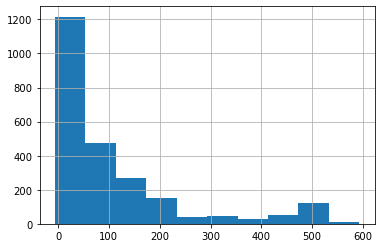

In [49]:
sample["distance"].hist()

<AxesSubplot:>

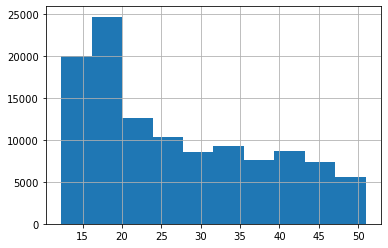

In [51]:
everybody[everybody["distance.bins"] == 1]["distance"].hist()

In [111]:
sample_vlow.to_csv("/Users/federicopigozzi/Desktop/PhD/co-evolution_GECCO_21/VSRBiodiversity/dataset_vlow.csv", sep=";", index=False)
sample_vhigh.to_csv("/Users/federicopigozzi/Desktop/PhD/co-evolution_GECCO_21/VSRBiodiversity/dataset_vhigh.csv", sep=";", index=False)

In [ ]:
# num.voxels = [5, 70]
# elongation = [1.0, 4.0]
# eccentricity = [0.5, 1.0]
# distance = [0.0, 575]

In [213]:
everybody[(everybody["elongation"] <= 4.0) & (everybody["num.voxels"] <= 70) & (everybody["num.voxels"] >= 5) & (everybody["eccentricity"] >= 0.5) & (everybody["distance"] <= 575)].shape

(457750, 22)

In [25]:
data = pd.read_csv("/Users/federicopigozzi/Desktop/PhD/co-evolution_GECCO_21/VSRBiodiversity/dataset.csv", sep=";")

<AxesSubplot:>

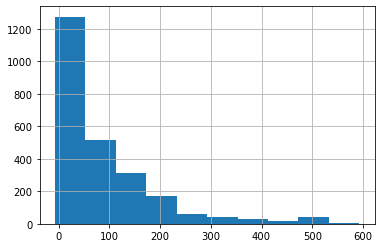

In [26]:
data["distance"].hist()

In [53]:
data = pd.read_csv("/Users/federicopigozzi/Desktop/PhD/co-evolution_GECCO_21/VSRBiodiversity/dataset_vhigh.csv", sep=";")

<AxesSubplot:>

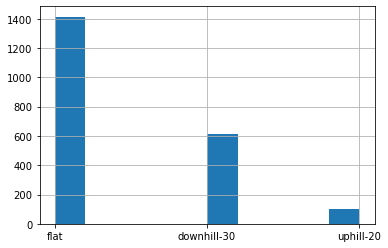

In [54]:
data["terrain"].hist()

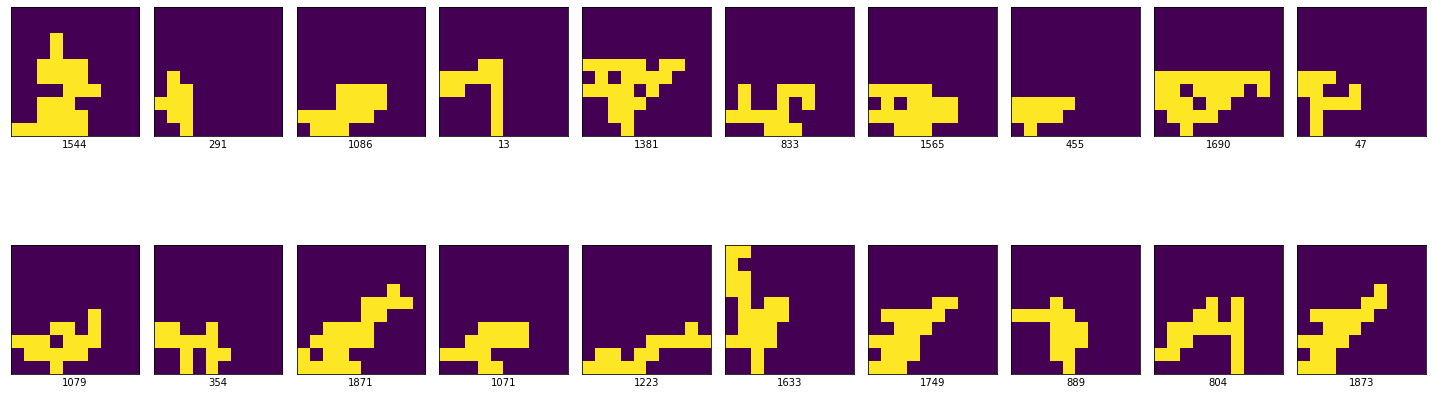

In [23]:
data = pd.read_csv("/Users/federicopigozzi/Desktop/PhD/co-evolution_GECCO_21/VSRBiodiversity/dataset.csv", sep=";").sample(20)
fig, axes = plt.subplots(figsize=(20, 8), nrows=2, ncols=10)

idx = 0
for i, row in data.iterrows():
    image = process_static_posture_pretty(row)
    row = idx // 10
    col = idx % 10
    axes[row][col].imshow(image)
    axes[row][col].set_xticks([])
    axes[row][col].set_yticks([])
    axes[row][col].set_xlabel(str(i))
    idx += 1
    
fig.tight_layout()

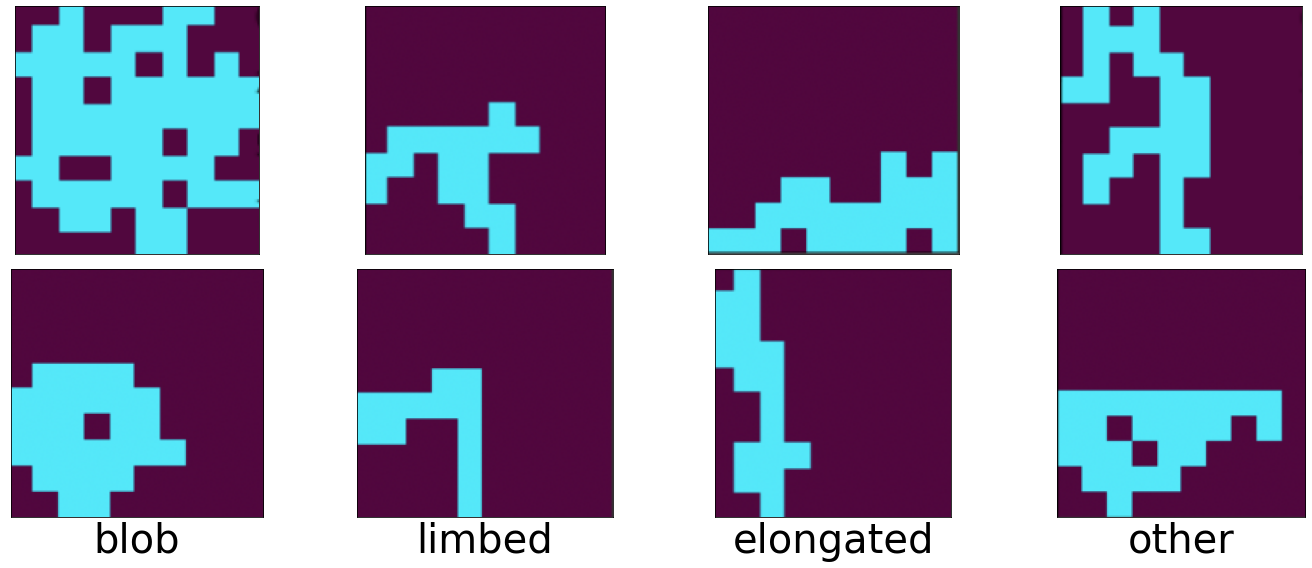

In [24]:
path = "/Users/federicopigozzi/Desktop/PhD/co-evolution_GECCO_21/VSRBiodiversity/shapes/"
fig, axes = plt.subplots(figsize=(20, 8), nrows=2, ncols=4)
cols = {"blob": 0, "limbed": 1, "elongated": 2, "other": 3}

for file in os.listdir(path):
    if file == ".DS_Store":
        continue
    image = cv2.imread(os.path.join(path, file))
    row = 0 if "1" in file else 1
    col = cols[file.split(".")[0][:-1]]
    axes[row][col].imshow(image)
    axes[row][col].set_xticks([])
    axes[row][col].set_yticks([])

for key, value in cols.items():
    axes[1][value].set_xlabel(key, fontsize=40)
    
fig.tight_layout()

In [ ]:
# 1) rifare istogramma diviso per 5x2.
# 2) tutta l'evoluzione solo sulla generazione iniziale e solo su quella finale (3 matrici di istogrammi)
# 3) rifare anche per il 5x5, almeno nel caso complessivo
# 4) matrice complessiva iniziale e finale per lo scatterplot
# cose idealmente da fare: numero dei voxel come feature
# eventualmente per rifacimento esperimenti no CMA-ES ma ES con soliti paramentri
# per terreno solo Ho con due algoritmi (GA ed SE-shape) con due terreni, potrebbe bastare questo, ma dopo i grafici
# un grafico giusto per noi, una terza riga delle mappe, gli stessi partizionamenti e le stesse PC, ma un puntino per ogni robot annotato

In [ ]:
# diversita' al variare dei best, proviamo

In [ ]:
# verificare la postura per rotolanti, PCA per spettro, poi pensa ad aggiunta feature

In [ ]:
# fare una letta preliminare, segnare alcuni punti riguardo allo stile e la lingua inglese (come la cosa dell'attivo e del passivo), alcuni
# punti sulla completezza e sensatezza delle cose che vengono dette, c'è un claim e si verifica se è supportato, se c'è una speigazione
# deriva solo da osservazione empirica va bene, altrimenti bisogna chiedere argomentazione o dire e` troppo forte,
# commenti sulla struttura generale (abstract, introduzione che motiva meglio, related, approccio, validazione sperimentale)
# devi valutare approccio innovativo, e` nuovo sta cosa? e` complicato, gli autori riescono a speigare qualcosa di nuovo?
# se sei dell'argomento e fanno che tizio ha gia` fatto, se lo spiegano l'aspetto nuovo di solito ci si fida, da quanti
# difetti di questo genere hai sollevato estrai un voto sintetico complessivo.
# due frasi di riassunto, altre due frasi se e` pertinente, e` scritto bene, e` sound e innovativo, dopo per questi motivi
# raccomando accettazione ma cio` nonostante ci sono alcuni difetti, devi modulare la frase, ci sono grossi problemi che
# portano a raccomandare il rifiuto, oppure giustificazione per minor o major revision (journal), poi spieghi gli issues
# (2-3, non 500) che portano via il grosso. Lui chiude con minor points

In [69]:
# possibili opportunità: esperimenti senza i bug, seconda rappresentazione per il corpo (GMM), basterebbe fare l'analisi
# del bias della sola rappresentazione, le due varianti si differenziano sul tipo di bias che inducono sul fenotipo, in questo caso
# la morfologia
# probabilmente rifaremo con nuovo spettro dei due punti

In [ ]:
# inizio evoluzione e guardare, in teoria tutti uguali, media delle forme statiche, medie del dynamic posture, nella popolazione
# e la stessa cosa a fine evoluzione, tra EA e repr non dovrebbe cambiare ma solo a seconda del terreno, m repr e n EA e k terreni,
# questo numero di coppie, metti al centro le posture, un ultimo giro di esperimenti con GMM, 

In [ ]:
# nel paper partiamo con GA-homo, due varianti del brain e due del body, poi tutto il resto con Ho e diretta, che dovrebbe
# favorire la diversita', poi EA, infine fissando due EA mostriamo i terreni e si chiude la storia, nelle repr i bias, il corpo
# e quelle serie di grafici, quando parliamo dei terreni rimostriamo i plot delle repr per fare vedere come impattano

In [213]:
def mean_shape(data):
    shapes = data.apply(lambda row: process_static_posture_pretty(row), axis=1)
    return np.mean(shapes.tolist(), axis=0)

In [13]:
def plot_feature_by_evolver_and_repr(data, func, last):
    fig, axes = plt.subplots(figsize=(25, 10), nrows=2, ncols=5)
    evolver_to_idx = {"es": 0, "ga": 1, "se-geno": 2, "se-shape": 3, "se-behaviour": 4}

    num = 0
    l = data[func].max()
    for (e, c), traj in data.groupby(["evolver", "controller"]):
        if last:
            traj = traj[traj["iterations"] == traj["iterations"].max()]
        else:
            traj = traj[traj["iterations"] == 0]
        col = evolver_to_idx[e]
        row = 0 if c == "homogeneous" else 1
        traj.hist(column=func, bins=10, ax=axes[row][col])
        axes[row][col].set_title("")
        #axes[row][col].set_xlim(0, l)
        num += 1
    
    pad = 5
    for ax, col in zip(axes[0], list(evolver_to_idx.keys())):
        ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size=20, ha='center', va='baseline')

    for ax, row in zip(axes[:,0], ["homogeneous", "heterogeneous"]):
        ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size=20, ha='right', va='center')
    
    fig.tight_layout()
    fig.subplots_adjust(left=0.15, top=0.95)

In [34]:
everybody["elongation"] = everybody["elongation"].astype(np.float64)
everybody["num.voxels"] = everybody["num.voxels"].astype(np.int32)

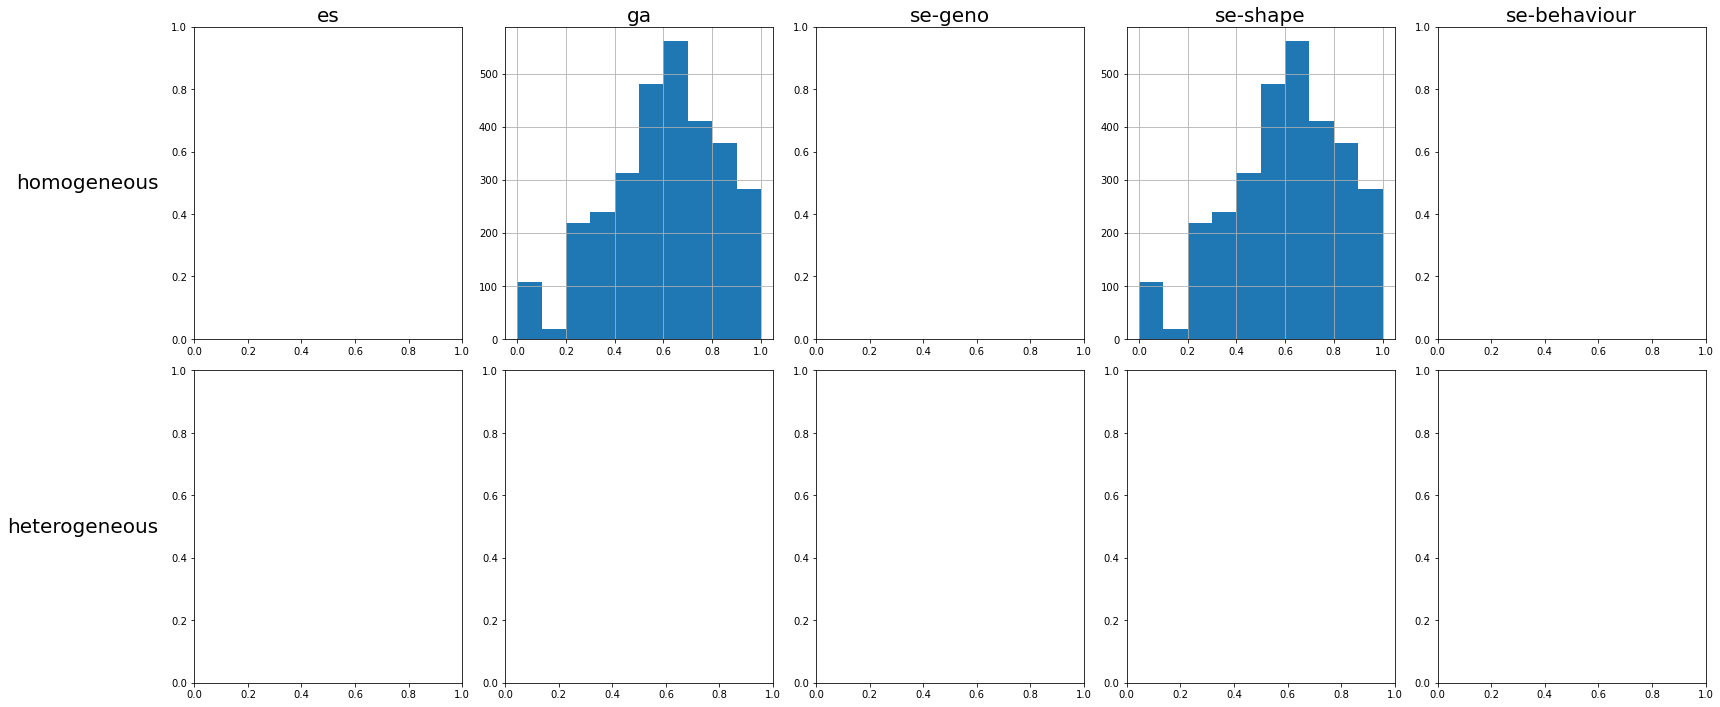

In [24]:
plot_feature_by_evolver_and_repr(everybody, "elongation", last=True)

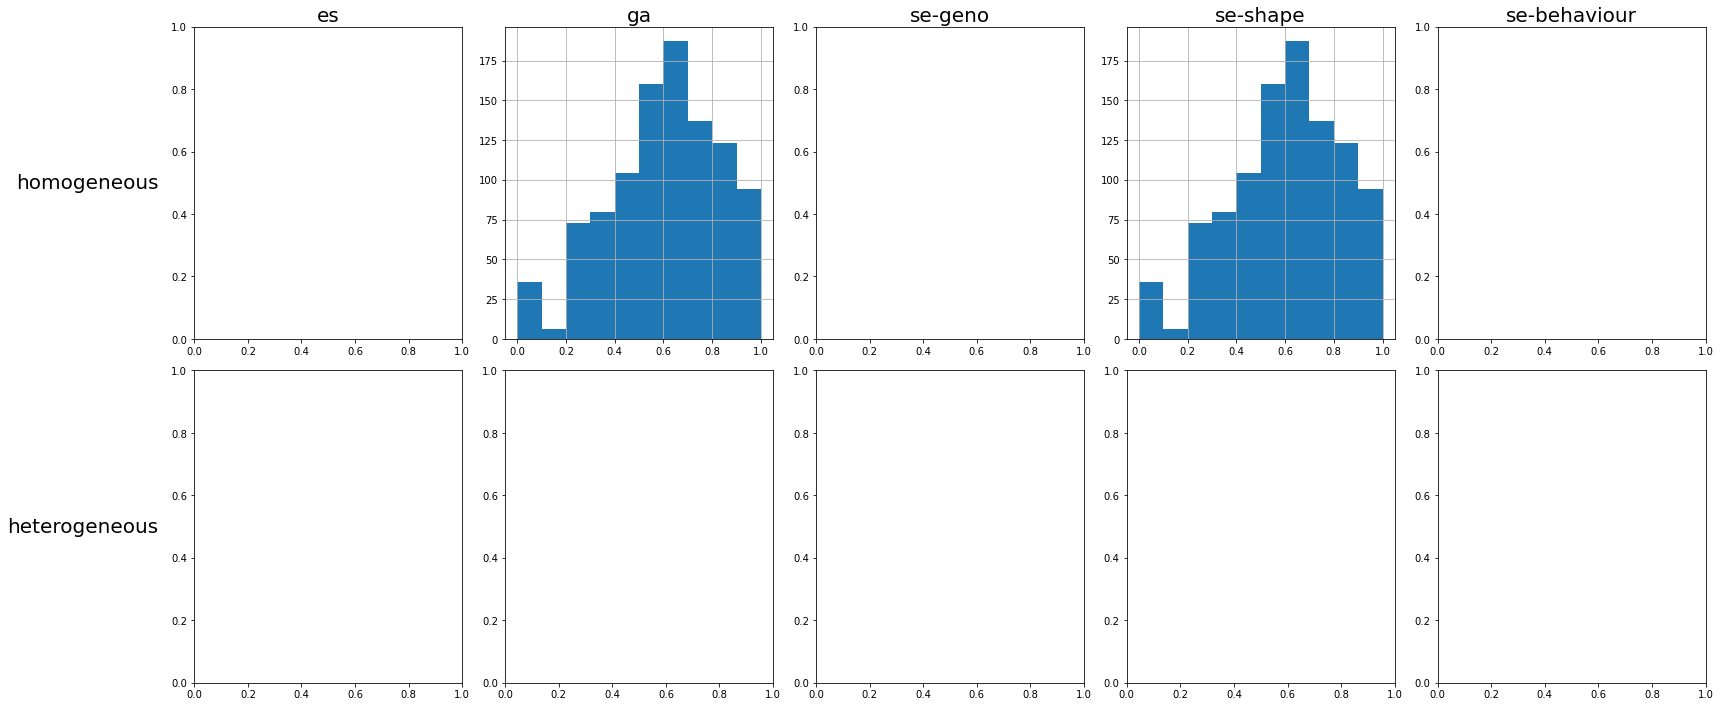

In [25]:
plot_feature_by_evolver_and_repr(everybody[everybody["terrain"] == "flat"], "elongation", last=True)

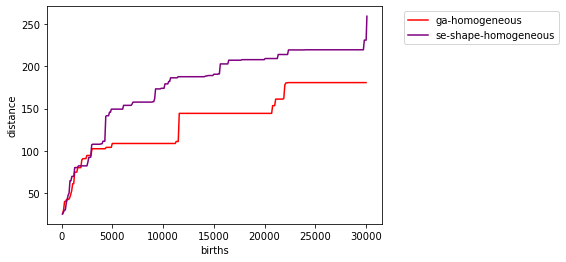

In [21]:
plot_fitness(bests[bests["terrain"] == "flat"])

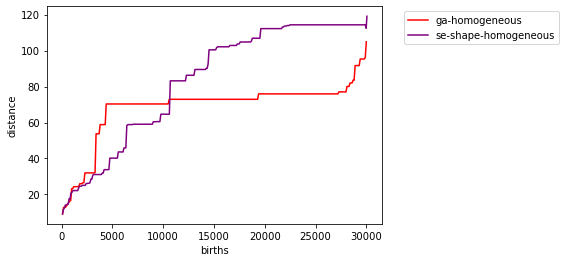

In [22]:
plot_fitness(bests[bests["terrain"] == "uphill-20"])

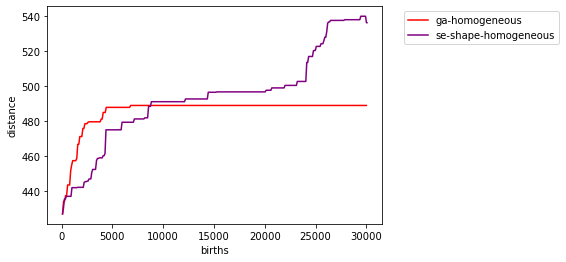

In [23]:
plot_fitness(bests[bests["terrain"] == "downhill-30"])

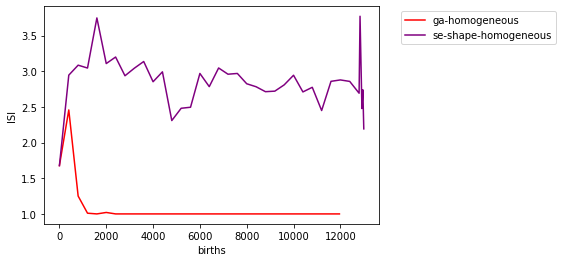

In [25]:
plot_simpson_index(everybody[everybody["terrain"] == "flat"])

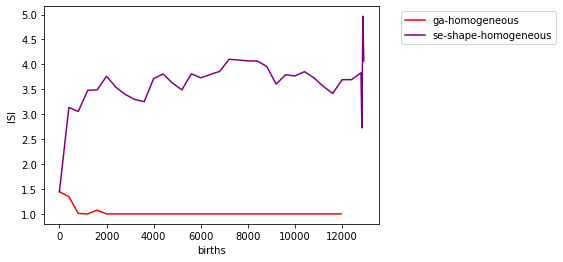

In [26]:
plot_simpson_index(everybody[everybody["terrain"] == "uphill-20"])

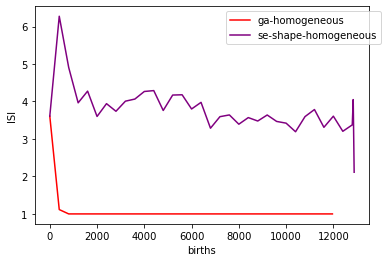

In [27]:
plot_simpson_index(everybody[everybody["terrain"] == "downhill-30"])

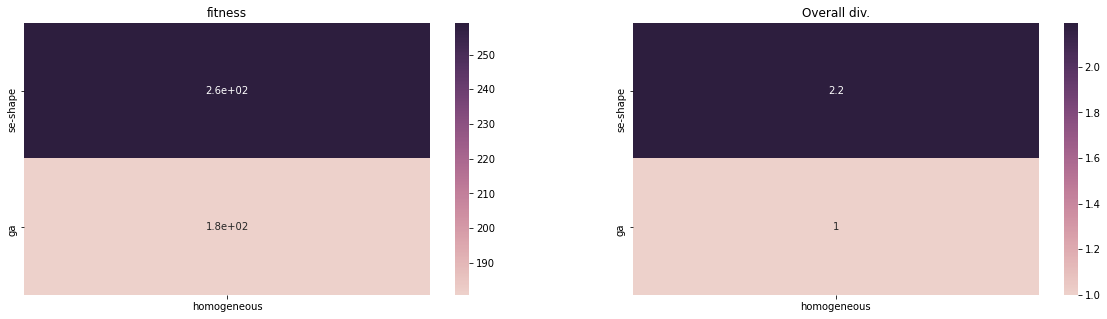

In [28]:
plot_last_iteration_metrics(everybody[everybody["terrain"] == "flat"])

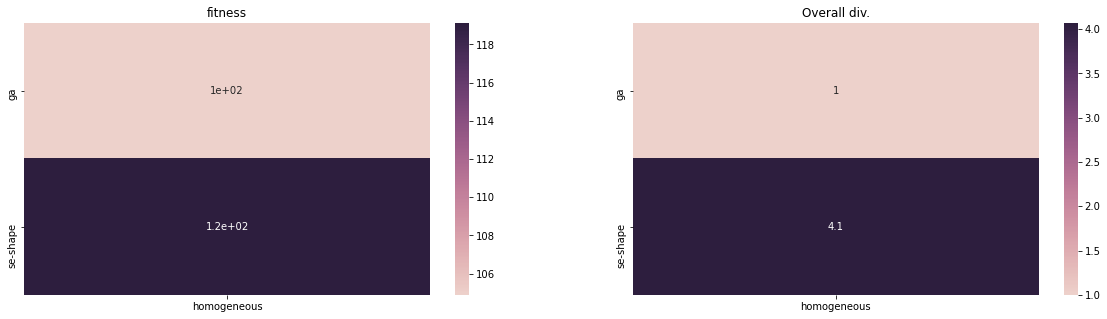

In [29]:
plot_last_iteration_metrics(everybody[everybody["terrain"] == "uphill-20"])

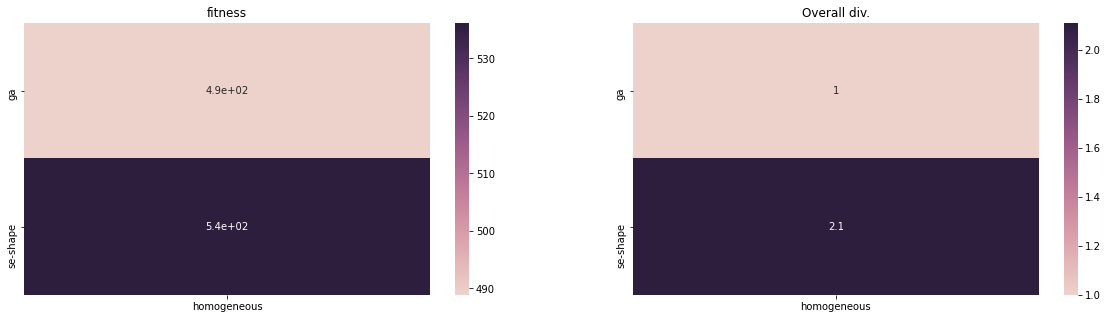

In [30]:
plot_last_iteration_metrics(everybody[everybody["terrain"] == "downhill-30"])

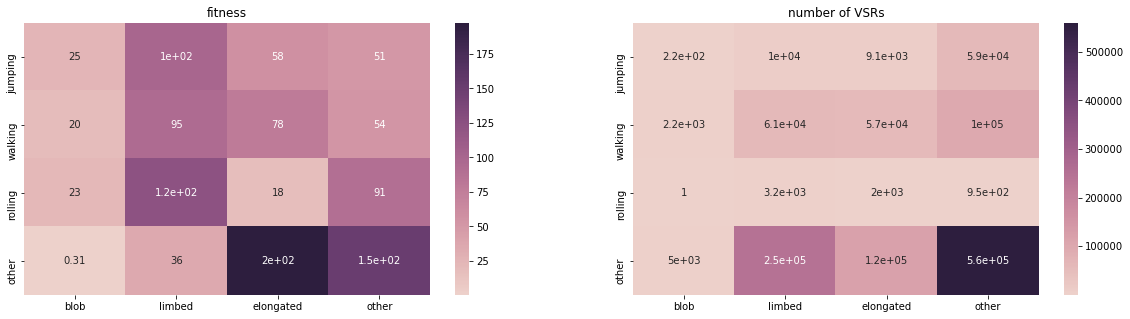

In [31]:
plot_last_iteration_species(everybody[everybody["terrain"] == "flat"])

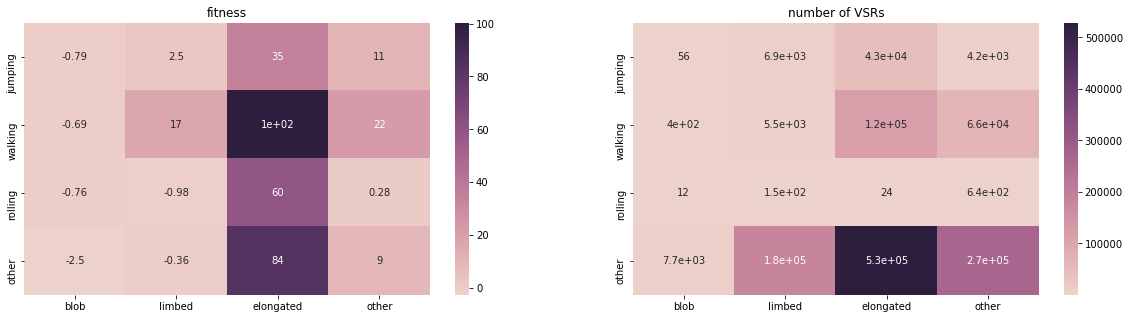

In [32]:
plot_last_iteration_species(everybody[everybody["terrain"] == "uphill-20"])

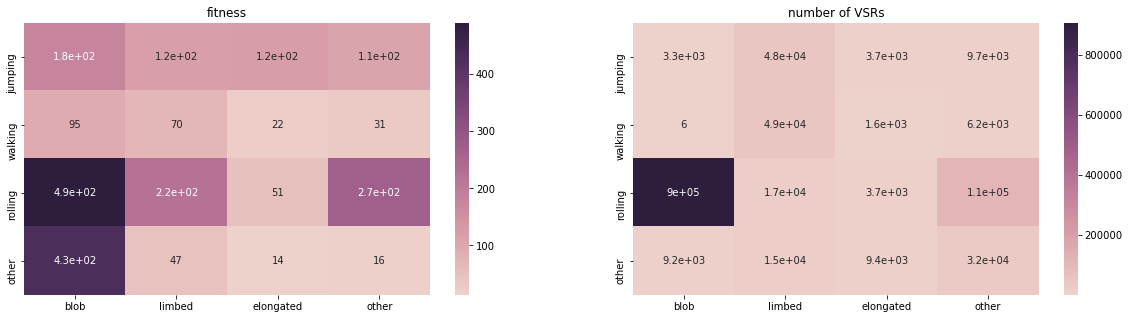

In [33]:
plot_last_iteration_species(everybody[everybody["terrain"] == "downhill-30"])

In [23]:
from mpl_toolkits import mplot3d


def plot_descriptors_scatterplot(data, plot=False):
    b = pd.DataFrame(columns=data.columns)
    for (e, c, r, t, m), traj in data.groupby(["evolver", "controller", "run", "terrain", "morphology"]):
        temp = traj[traj["iterations"] == traj["iterations"].max()]
        b = b.append(temp[temp["velocity"] == temp["velocity"].max()].sample(1))
    if plot:
        sns.scatterplot(data=b, x="elongation", y="eccentricity", hue="morphology", size="num.voxels")
        plt.ylabel("compactness")
    return b

In [30]:
everybody[(everybody["morphology"] == "gmm") & (everybody["evolver"] == "se-shape")]["run"].unique()#.shape

array([9, 5, 3, 8, 4, 2, 6, 0, 7, 1], dtype=object)

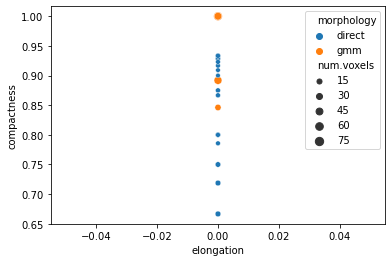

In [159]:
_ = plot_descriptors_scatterplot(everybody[((everybody["evolver"] == "ga") | (everybody["evolver"] == "se-shape")) & (everybody["terrain"] == "flat") & (everybody["controller"] == "homogeneous")])

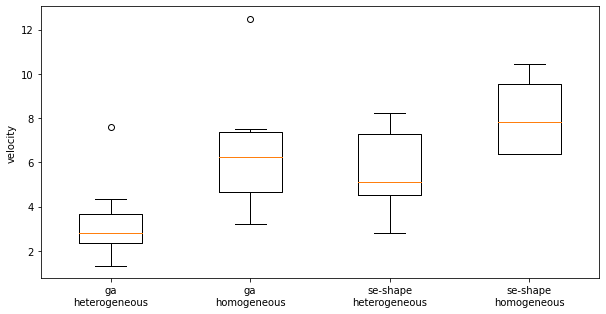

In [68]:
plot_fitness_boxplot(bests[((bests["evolver"] == "ga") | (bests["evolver"] == "se-shape")) & (bests["terrain"] == "flat")], by="controller")

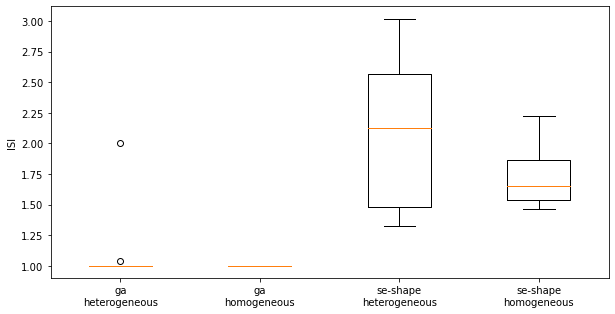

In [117]:
plot_simpson_index_boxplot(everybody[((everybody["evolver"] == "ga") | (everybody["evolver"] == "se-shape")) & (everybody["terrain"] == "flat")])

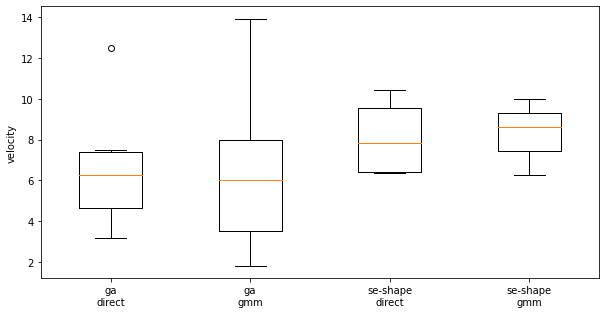

In [57]:
plot_fitness_boxplot(bests[((bests["evolver"] == "ga") | (bests["evolver"] == "se-shape")) & (bests["terrain"] == "flat") & (bests["controller"] == "homogeneous")])

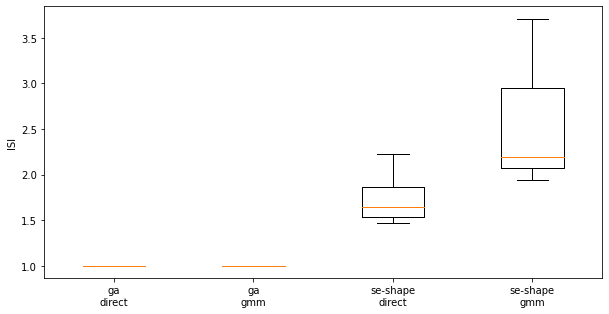

In [53]:
plot_simpson_index_boxplot(everybody[((everybody["evolver"] == "ga") | (everybody["evolver"] == "se-shape")) & (everybody["terrain"] == "flat") & (everybody["controller"] == "homogeneous")], by="morphology")

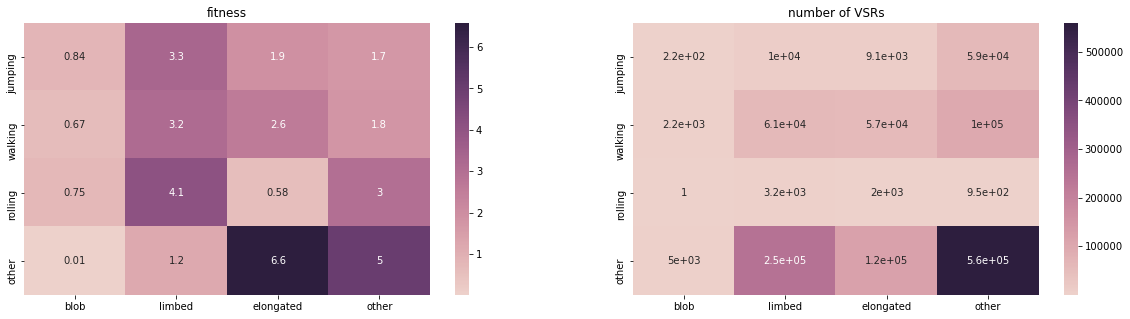

In [70]:
plot_last_iteration_species(everybody[((everybody["evolver"] == "ga") | (everybody["evolver"] == "se-shape")) & (everybody["terrain"] == "flat") & (everybody["controller"] == "homogeneous") & (everybody["morphology"] == "gmm")])

In [ ]:
#everybody[(everybody["terrain"] == "flat") & (everybody["controler"] == "homogeneous")].boxplot(by=["evolver"], column="distance")

In [ ]:
#everybody[(everybody["terrain"] == "flat") & (everybody["controler"] == "homogeneous")].boxplot(by=["evolver"], column="all.diversity")

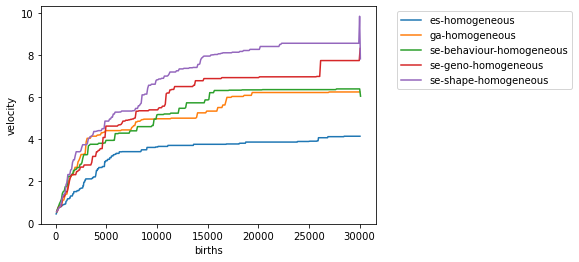

In [61]:
plot_fitness(bests[(bests["terrain"] == "flat") & (bests["controller"] == "homogeneous")])

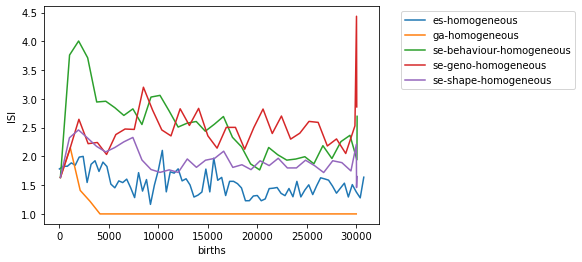

In [103]:
plot_simpson_index(everybody[(everybody["terrain"] == "flat") & (everybody["controller"] == "homogeneous")])

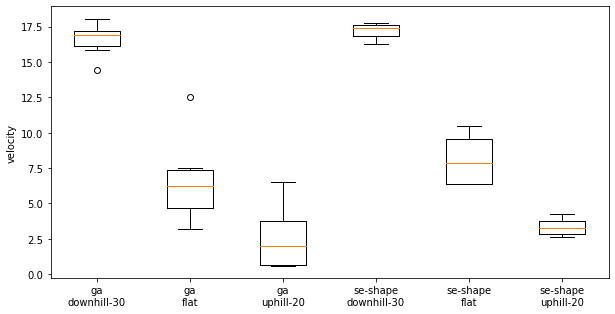

In [31]:
plot_fitness_boxplot(bests[((bests["evolver"] == "ga") | (bests["evolver"] == "se-shape")) & (bests["controller"] == "homogeneous")], by="terrain")

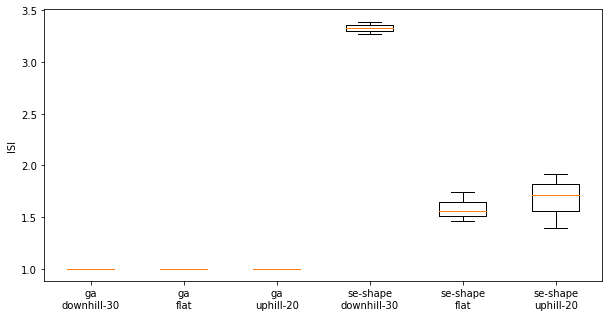

In [35]:
plot_simpson_index_boxplot(everybody[((everybody["evolver"] == "ga") | (everybody["evolver"] == "se-shape")) & (everybody["controller"] == "homogeneous")], by="terrain")

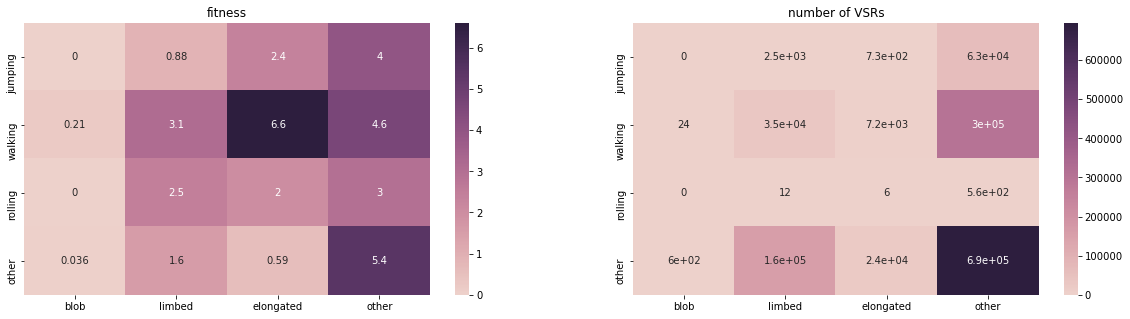

In [62]:
plot_last_iteration_species(everybody[((everybody["evolver"] == "ga") | (everybody["evolver"] == "se-shape")) & (everybody["terrain"] == "flat") & (everybody["controller"] == "homogeneous") & (everybody["morphology"] == "direct")])

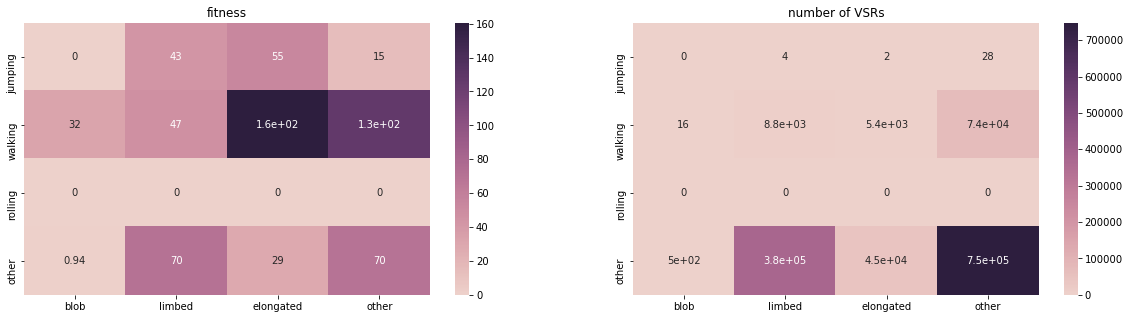

In [132]:
plot_last_iteration_species(everybody[((everybody["evolver"] == "ga") | (everybody["evolver"] == "se-shape")) & (everybody["terrain"] == "flat") & (everybody["controller"] == "heterogeneous") & (everybody["morphology"] == "direct")])

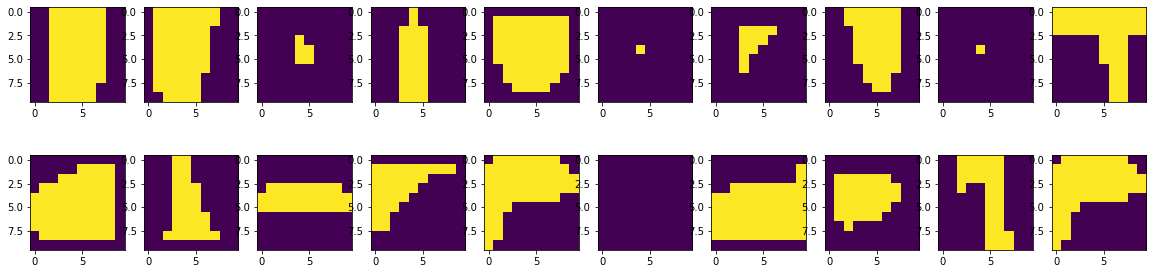

In [14]:
fig, axes = plt.subplots(figsize=(20, 5), nrows=2, ncols=10)
sample = everybody[everybody["morphology"] == "gmm"].sample(20)
num = 0
for row in range(2):
    for col in range(10):
        axes[row][col].imshow(process_static_posture_pretty(sample.iloc[num]))
        num += 1

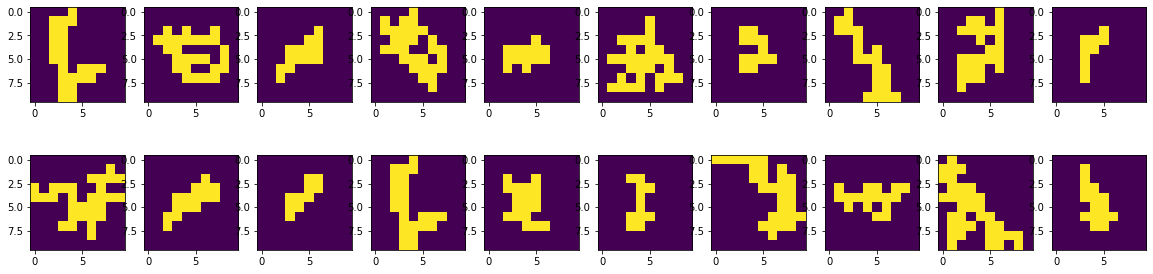

In [16]:
fig, axes = plt.subplots(figsize=(20, 5), nrows=2, ncols=10)
sample = everybody[everybody["morphology"] == "direct"].sample(20)
num = 0
for row in range(2):
    for col in range(10):
        axes[row][col].imshow(process_static_posture_pretty(sample.iloc[num]))
        num += 1

Text(0, 0.5, 'velocity')

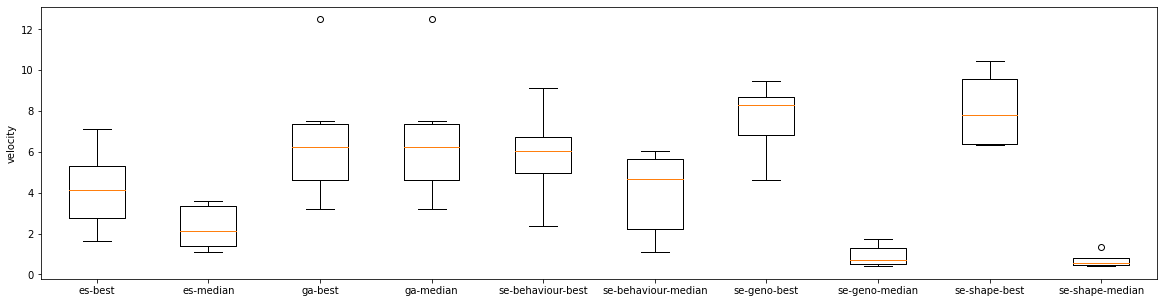

In [48]:
fig, ax = plt.subplots(figsize=(20, 5), nrows=1, ncols=1)
ax.boxplot(d.values())
ax.set_xticklabels(d.keys())
ax.set_ylabel("velocity")

In [ ]:
# ISI e velocita' in file diversi per figura 5, per la 6 stessa cosa morphology, per le heatmap, un file con 16 righe e 4
# colonne, le due colonne sono le due etichette e le altre due colonne sono i due numeri v_x e rate con valori in
# percentuale sulla popolazione, mediane tra run, la figura 8 semplice con 4 colonne, o due file tra 3 colonne meglio,
# quelle degli indicatori, questa avra' due file, un file per ogni indicatore, e quattro colonne, direct_first direct_last
# gmm_first gmm_last, la figura 11 normale ci abbiamo 10 colonne piu' il numero di iterazioni, un file con 11 colonne
# che sono il prodotto cartesiano di ISI, velocity e EA, heatmap come prima, la figura 13 come per i boxplot di prima ma
# ha un gruppo di colonne in piu', PCA ci vuole un file per ogni gruppo di puntini, con 4 colonne shape e behavior, un file per ognuno
# dei gruppi

In [85]:
file = pd.DataFrame()
for label, traj in bests[((bests["evolver"] == "ga") | (bests["evolver"] == "se-shape")) & (bests["terrain"] == "flat") & (bests["morphology"] == "direct")].groupby(["evolver", "controller"]):
    values = []
    for _ , t in traj.groupby(["run"]):
        values.append(t[t["iterations"] == t["iterations"].max()]["velocity"].item())
    print(len(values))
    file["_".join(label)] = values
file.to_csv("rq1_controller_velocity_boxplot.txt", sep=" ", index=False)
for label1 in file.columns:
    for label2 in file.columns:
        if label1 == label2:
            continue
        print(" ".join([label1, label2, str(mannwhitneyu(file[label1], file[label2], alternative="two-sided"))]))

10
10
10
10
ga_heterogeneous ga_homogeneous MannwhitneyuResult(statistic=13.0, pvalue=0.00579535854433471)
ga_heterogeneous se-shape_heterogeneous MannwhitneyuResult(statistic=15.0, pvalue=0.009108496398030965)
ga_heterogeneous se-shape_homogeneous MannwhitneyuResult(statistic=3.0, pvalue=0.00043963875262656454)
ga_homogeneous ga_heterogeneous MannwhitneyuResult(statistic=87.0, pvalue=0.00579535854433471)
ga_homogeneous se-shape_heterogeneous MannwhitneyuResult(statistic=55.0, pvalue=0.7337299956962472)
ga_homogeneous se-shape_homogeneous MannwhitneyuResult(statistic=22.0, pvalue=0.03763531378731424)
se-shape_heterogeneous ga_heterogeneous MannwhitneyuResult(statistic=85.0, pvalue=0.009108496398030965)
se-shape_heterogeneous ga_homogeneous MannwhitneyuResult(statistic=45.0, pvalue=0.7337299956962472)
se-shape_heterogeneous se-shape_homogeneous MannwhitneyuResult(statistic=17.0, pvalue=0.014019277113959953)
se-shape_homogeneous ga_heterogeneous MannwhitneyuResult(statistic=97.0, pvalue=

In [82]:
file = pd.DataFrame()
for label, traj in everybody[((everybody["evolver"] == "ga") | (everybody["evolver"] == "se-shape")) & (everybody["terrain"] == "flat") & (everybody["morphology"] == "direct")].groupby(["evolver", "controller"]):
    values = []
    for _ , t in traj.groupby(["run"]):
        values.append(t[t["iterations"] == t["iterations"].max()]["all.diversity"].median())
    print(len(values))
    file["_".join(label)] = values
file.to_csv("rq1_controller_ISI_boxplot.txt", sep=" ", index=False)
for label1 in file.columns:
    for label2 in file.columns:
        if label1 == label2:
            continue
        print(" ".join([label1, label2, str(mannwhitneyu(file[label1], file[label2], alternative="two-sided"))]))

10
10
10
10
ga_heterogeneous ga_homogeneous MannwhitneyuResult(statistic=60.0, pvalue=0.16807831903497028)
ga_heterogeneous se-shape_heterogeneous MannwhitneyuResult(statistic=4.0, pvalue=0.00038010747425907176)
ga_heterogeneous se-shape_homogeneous MannwhitneyuResult(statistic=8.0, pvalue=0.0011905868119777784)
ga_homogeneous ga_heterogeneous MannwhitneyuResult(statistic=40.0, pvalue=0.16807831903497028)
ga_homogeneous se-shape_heterogeneous MannwhitneyuResult(statistic=0.0, pvalue=6.386444750436982e-05)
ga_homogeneous se-shape_homogeneous MannwhitneyuResult(statistic=0.0, pvalue=6.386444750436982e-05)
se-shape_heterogeneous ga_heterogeneous MannwhitneyuResult(statistic=96.0, pvalue=0.00038010747425907176)
se-shape_heterogeneous ga_homogeneous MannwhitneyuResult(statistic=100.0, pvalue=6.386444750436982e-05)
se-shape_heterogeneous se-shape_homogeneous MannwhitneyuResult(statistic=63.0, pvalue=0.3447042220069576)
se-shape_homogeneous ga_heterogeneous MannwhitneyuResult(statistic=92.0, 

In [86]:
file = pd.DataFrame()
for label, traj in bests[((bests["evolver"] == "ga") | (bests["evolver"] == "se-shape")) & (bests["terrain"] == "flat") & (bests["controller"] == "homogeneous")].groupby(["evolver", "morphology"]):
    values = []
    for _ , t in traj.groupby(["run"]):
        values.append(t[t["iterations"] == t["iterations"].max()]["velocity"].item())
    print(len(values))
    file["_".join(label)] = values
file.to_csv("rq1_morphology_velocity_boxplot.txt", sep=" ", index=False)
for label1 in file.columns:
    for label2 in file.columns:
        if label1 == label2:
            continue
        print(" ".join([label1, label2, str(mannwhitneyu(file[label1], file[label2], alternative="two-sided"))]))

10
10
10
10
ga_direct ga_gmm MannwhitneyuResult(statistic=54.0, pvalue=0.7913367801006604)
ga_direct se-shape_direct MannwhitneyuResult(statistic=22.0, pvalue=0.03763531378731424)
ga_direct se-shape_gmm MannwhitneyuResult(statistic=30.0, pvalue=0.14046504815835495)
ga_gmm ga_direct MannwhitneyuResult(statistic=46.0, pvalue=0.7913367801006604)
ga_gmm se-shape_direct MannwhitneyuResult(statistic=29.0, pvalue=0.12122450301291662)
ga_gmm se-shape_gmm MannwhitneyuResult(statistic=32.0, pvalue=0.18587673236587576)
se-shape_direct ga_direct MannwhitneyuResult(statistic=78.0, pvalue=0.03763531378731424)
se-shape_direct ga_gmm MannwhitneyuResult(statistic=71.0, pvalue=0.12122450301291662)
se-shape_direct se-shape_gmm MannwhitneyuResult(statistic=64.0, pvalue=0.3074894566186813)
se-shape_gmm ga_direct MannwhitneyuResult(statistic=70.0, pvalue=0.14046504815835495)
se-shape_gmm ga_gmm MannwhitneyuResult(statistic=68.0, pvalue=0.18587673236587576)
se-shape_gmm se-shape_direct MannwhitneyuResult(sta

In [87]:
file = pd.DataFrame()
for label, traj in everybody[((everybody["evolver"] == "ga") | (everybody["evolver"] == "se-shape")) & (everybody["terrain"] == "flat") & (everybody["controller"] == "homogeneous")].groupby(["evolver", "morphology"]):
    values = []
    for _ , t in traj.groupby(["run"]):
        values.append(t[t["iterations"] == t["iterations"].max()]["all.diversity"].median())
    print(len(values))
    file["_".join(label)] = values
file.to_csv("rq1_morphology_ISI_boxplot.txt", sep=" ", index=False)
for label1 in file.columns:
    for label2 in file.columns:
        if label1 == label2:
            continue
        try:
            print(" ".join([label1, label2, str(mannwhitneyu(file[label1], file[label2], alternative="two-sided"))]))
        except:
            print(" ".join([label1, label2, "FAILURE"]))

10
10
10
10
ga_direct ga_gmm FAILURE
ga_direct se-shape_direct MannwhitneyuResult(statistic=0.0, pvalue=6.386444750436982e-05)
ga_direct se-shape_gmm MannwhitneyuResult(statistic=0.0, pvalue=6.386444750436982e-05)
ga_gmm ga_direct FAILURE
ga_gmm se-shape_direct MannwhitneyuResult(statistic=0.0, pvalue=6.386444750436982e-05)
ga_gmm se-shape_gmm MannwhitneyuResult(statistic=0.0, pvalue=6.386444750436982e-05)
se-shape_direct ga_direct MannwhitneyuResult(statistic=100.0, pvalue=6.386444750436982e-05)
se-shape_direct ga_gmm MannwhitneyuResult(statistic=100.0, pvalue=6.386444750436982e-05)
se-shape_direct se-shape_gmm MannwhitneyuResult(statistic=8.0, pvalue=0.0017062493689195964)
se-shape_gmm ga_direct MannwhitneyuResult(statistic=100.0, pvalue=6.386444750436982e-05)
se-shape_gmm ga_gmm MannwhitneyuResult(statistic=100.0, pvalue=6.386444750436982e-05)
se-shape_gmm se-shape_direct MannwhitneyuResult(statistic=92.0, pvalue=0.0017062493689195964)


In [91]:
file = pd.DataFrame()
for label, traj in bests[((bests["evolver"] == "ga") | (bests["evolver"] == "se-shape")) & (bests["morphology"] == "direct") & (bests["controller"] == "homogeneous")].groupby(["evolver", "terrain"]):
    values = []
    for _ , t in traj.groupby(["run"]):
        values.append(t[t["iterations"] == t["iterations"].max()]["velocity"].item())
    print(len(values))
    file["_".join(label)] = values
#file.to_csv("rq3_terrain_velocity_boxplot.txt", sep=" ", index=False)
for label1 in file.columns:
    for label2 in file.columns:
        if label1 == label2:
            continue
        print(" ".join([label1, label2, str(mannwhitneyu(file[label1], file[label2], alternative="two-sided"))]))

10
10
10
10
10
10
ga_downhill-30 ga_flat MannwhitneyuResult(statistic=100.0, pvalue=0.00018267179110955002)
ga_downhill-30 ga_uphill-20 MannwhitneyuResult(statistic=100.0, pvalue=0.00018267179110955002)
ga_downhill-30 se-shape_downhill-30 MannwhitneyuResult(statistic=41.0, pvalue=0.5205228832757727)
ga_downhill-30 se-shape_flat MannwhitneyuResult(statistic=100.0, pvalue=0.00018267179110955002)
ga_downhill-30 se-shape_uphill-20 MannwhitneyuResult(statistic=100.0, pvalue=0.00018267179110955002)
ga_flat ga_downhill-30 MannwhitneyuResult(statistic=0.0, pvalue=0.00018267179110955002)
ga_flat ga_uphill-20 MannwhitneyuResult(statistic=92.0, pvalue=0.0017062493689195964)
ga_flat se-shape_downhill-30 MannwhitneyuResult(statistic=0.0, pvalue=0.00018267179110955002)
ga_flat se-shape_flat MannwhitneyuResult(statistic=22.0, pvalue=0.03763531378731424)
ga_flat se-shape_uphill-20 MannwhitneyuResult(statistic=87.0, pvalue=0.00579535854433471)
ga_uphill-20 ga_downhill-30 MannwhitneyuResult(statistic=0.

In [96]:
file = pd.DataFrame()
for label, traj in everybody[((everybody["evolver"] == "ga") | (everybody["evolver"] == "se-shape")) & (everybody["morphology"] == "direct") & (everybody["controller"] == "homogeneous")].groupby(["evolver", "terrain"]):
    values = []
    for _ , t in traj.groupby(["run"]):
        values.append(t[t["iterations"] == t["iterations"].max()]["all.diversity"].median())
    print(len(values))
    if len(values) < 10:
        values.append(np.median(values))
    file["_".join(label)] = values
file.to_csv("rq3_terrain_ISI_boxplot.txt", sep=" ", index=False)
for label1 in file.columns:
    for label2 in file.columns:
        if label1 == label2:
            continue
        try:
            print(" ".join([label1, label2, str(mannwhitneyu(file[label1], file[label2], alternative="two-sided"))]))
        except:
            print(" ".join([label1, label2, "FAILURE"]))

10
10
9
10
10
10
ga_downhill-30 ga_flat FAILURE
ga_downhill-30 ga_uphill-20 FAILURE
ga_downhill-30 se-shape_downhill-30 MannwhitneyuResult(statistic=0.0, pvalue=6.386444750436982e-05)
ga_downhill-30 se-shape_flat MannwhitneyuResult(statistic=0.0, pvalue=6.386444750436982e-05)
ga_downhill-30 se-shape_uphill-20 MannwhitneyuResult(statistic=0.0, pvalue=6.386444750436982e-05)
ga_flat ga_downhill-30 FAILURE
ga_flat ga_uphill-20 FAILURE
ga_flat se-shape_downhill-30 MannwhitneyuResult(statistic=0.0, pvalue=6.386444750436982e-05)
ga_flat se-shape_flat MannwhitneyuResult(statistic=0.0, pvalue=6.386444750436982e-05)
ga_flat se-shape_uphill-20 MannwhitneyuResult(statistic=0.0, pvalue=6.386444750436982e-05)
ga_uphill-20 ga_downhill-30 FAILURE
ga_uphill-20 ga_flat FAILURE
ga_uphill-20 se-shape_downhill-30 MannwhitneyuResult(statistic=0.0, pvalue=6.386444750436982e-05)
ga_uphill-20 se-shape_flat MannwhitneyuResult(statistic=0.0, pvalue=6.386444750436982e-05)
ga_uphill-20 se-shape_uphill-20 Mannwhitn

In [93]:
file = pd.DataFrame()
for label, traj in everybody[(everybody["terrain"] == "flat") & (everybody["morphology"] == "direct") & (everybody["controller"] == "homogeneous")].groupby(["evolver"]):
    values = []
    for _ , t in traj.groupby(["run"]):
        values.append(t[t["iterations"] == t["iterations"].max()]["velocity"].median())
    print(len(values))
    file["_".join([label, "median"])] = values
    values = []
    for _ , t in traj.groupby(["run"]):
        values.append(t[t["iterations"] == t["iterations"].max()]["velocity"].max())
    file["_".join([label, "best"])] = values
file.to_csv("rq2_ea_best_median_boxplot.txt", sep=" ", index=False)
for label1 in file.columns:
    for label2 in file.columns:
        if label1 == label2:
            continue
        print(" ".join([label1, label2, str(mannwhitneyu(file[label1], file[label2], alternative="two-sided"))]))

10
10
10
10
10
es_median es_best MannwhitneyuResult(statistic=18.0, pvalue=0.017257456083119765)
es_median ga_median MannwhitneyuResult(statistic=3.0, pvalue=0.00043963875262656454)
es_median ga_best MannwhitneyuResult(statistic=3.0, pvalue=0.00043963875262656454)
es_median se-behaviour_median MannwhitneyuResult(statistic=23.0, pvalue=0.04515456962427901)
es_median se-behaviour_best MannwhitneyuResult(statistic=5.0, pvalue=0.0007685389131627665)
es_median se-geno_median MannwhitneyuResult(statistic=89.0, pvalue=0.0036105143123296027)
es_median se-geno_best MannwhitneyuResult(statistic=0.0, pvalue=0.00018267179110955002)
es_median se-shape_median MannwhitneyuResult(statistic=59.0, pvalue=0.5205228832757727)
es_median se-shape_best MannwhitneyuResult(statistic=0.0, pvalue=0.00018267179110955002)
es_best es_median MannwhitneyuResult(statistic=82.0, pvalue=0.017257456083119765)
es_best ga_median MannwhitneyuResult(statistic=22.0, pvalue=0.03763531378731424)
es_best ga_best MannwhitneyuResu

In [103]:
file = pd.DataFrame()
for label, traj in bests[(bests["terrain"] == "flat") & (bests["morphology"] == "direct") & (bests["controller"] == "homogeneous")].groupby(["evolver"]):
    x = []
    values = []
    val = 0
    for it, t in traj.groupby(["iterations"]):
        b = t["births"].median()
        if b > val and len(values) < 30:
            val += 1000
            x.append(val / 1000)
            values.append(t.groupby(t.run)["velocity"].max().median())
    print(len(values), traj.shape)
    file[label] = values
file.to_csv("rq2_ea_velocity_lineplot.txt", sep=" ")

30 (7700, 13)
30 (3000, 13)
30 (3285, 13)
30 (3229, 13)
30 (3272, 13)


In [104]:
file = pd.DataFrame()
for label, traj in everybody[(everybody["terrain"] == "flat") & (everybody["morphology"] == "direct") & (everybody["controller"] == "homogeneous")].groupby(["evolver"]):
    x = []
    values = []
    val = 0
    for it, t in traj.groupby(["iterations"]):
        b = t["births"].median()
        if b > val and len(values) < 30:
            val += 1000
            x.append(val / 1000)
            values.append(t.groupby(t.run)["all.diversity"].max().median())
    print(len(values), traj.shape)
    file[label] = values
file.to_csv("rq2_ea_ISI_lineplot.txt", sep=" ")

30 (31200, 23)
30 (31000, 23)
30 (34000, 23)
30 (34000, 23)
30 (34000, 23)


In [16]:
file = pd.DataFrame(columns=["shape", "behavior", "hetero.vx", "hetero.rate", "homo.vx", "homo.rate"])

rate_direct = np.zeros((10, 16))
fitness_direct = np.zeros((10, 16))

for r, traj in everybody[((everybody["evolver"] == "ga")) & (everybody["terrain"] == "flat") & (everybody["controller"] == "homogeneous") & (everybody["morphology"] == "direct")].groupby(["run"]):
    traj = traj[traj["iterations"] == traj["iterations"].max()]
    for s in shape_dict.keys():
        for b in behavior_dict.keys():
            temp = traj[(traj["shape.label"] == s) & (traj["behaviour.label"] == b)]
            fitness_direct[r, s * 4 + b] = np.mean(temp["velocity"])
            rate_direct[r, s * 4 + b] = len(temp) / 100
rate_direct = np.mean(rate_direct, axis=0)
fitness_direct = np.nanmean(fitness_direct, axis=0)

rate_gmm = np.zeros((10, 16))
fitness_gmm = np.zeros((10, 16))

for r, traj in everybody[((everybody["evolver"] == "ga")) & (everybody["terrain"] == "flat") & (everybody["controller"] == "heterogeneous") & (everybody["morphology"] == "direct")].groupby(["run"]):
    traj = traj[traj["iterations"] == traj["iterations"].max()]
    for s in shape_dict.keys():
        for b in behavior_dict.keys():
            temp = traj[(traj["shape.label"] == s) & (traj["behaviour.label"] == b)]
            fitness_gmm[r, s * 4 + b] = np.mean(temp["velocity"])
            rate_gmm[r, s * 4 + b] = len(temp) / 100
rate_gmm = np.mean(rate_gmm, axis=0)
fitness_gmm = np.nanmean(fitness_gmm, axis=0)

for row, s in shape_dict.items():
    for col, b in behavior_dict.items():
        file = file.append({"shape": s, "behavior": b, "homo.vx": fitness_direct[row * 4 + col],
                            "homo.rate": rate_direct[row * 4 + col], "hetero.vx": fitness_gmm[row * 4 + col],
                            "hetero.rate": rate_gmm[row * 4 + col]}, ignore_index=True)

file.to_csv("bub.ctrl.ga.txt", sep=" ", index=False, na_rep="nan")          

<ipython-input-16-f15d93994e68>:14: RuntimeWarning: Mean of empty slice
  fitness_direct = np.nanmean(fitness_direct, axis=0)
<ipython-input-16-f15d93994e68>:27: RuntimeWarning: Mean of empty slice
  fitness_gmm = np.nanmean(fitness_gmm, axis=0)


In [83]:
file = pd.DataFrame(columns=["shape.label", "behavior.label", "vx", "rate"])

rate = np.zeros((50, 16))
fitness = np.zeros((50, 16))
num_to_evolver = {"es": 0, "ga": 1, "se-geno": 2, "se-shape": 3, "se-behaviour": 4}

for (r, e), traj in everybody[(everybody["terrain"] == "flat") & (everybody["controller"] == "homogeneous") & (everybody["morphology"] == "direct")].groupby(["run", "evolver"]):
    traj = traj[traj["iterations"] == traj["iterations"].max()]
    for s in shape_dict.keys():
        for b in behavior_dict.keys():
            temp = traj[(traj["shape.label"] == s) & (traj["behaviour.label"] == b)]
            fitness[num_to_evolver[e] * 10 + r, s * 4 + b] = np.mean(temp["velocity"])
            pop = 100 if e != "es" else 40
            rate[num_to_evolver[e] * 10 + r, s * 4 + b] = len(temp) / pop
rate = np.mean(rate, axis=0)
fitness = np.nanmean(fitness, axis=0)

for row, s in shape_dict.items():
    for col, b in behavior_dict.items():
        file = file.append({"shape.label": s, "behavior.label": b, "vx": fitness[row * 4 + col],
                            "rate": rate[row * 4 + col]}, ignore_index=True)

file.to_csv("rq2_ea_heatmap.txt", sep=" ", index=False, na_rep="nan")          

<ipython-input-83-e20d1a72ae98>:16: RuntimeWarning: Mean of empty slice
  fitness = np.nanmean(fitness, axis=0)


In [25]:
desc = plot_descriptors_scatterplot(everybody[((everybody["evolver"] == "se-shape")) & (everybody["terrain"] == "flat") & (everybody["controller"] == "homogeneous")])
desc[desc["morphology"] == "direct"][["num.voxels", "elongation", "eccentricity"]].to_csv("rq1_morphology_se-shape_direct_descriptors_scatterplot.txt", sep=" ", index=False)
desc[desc["morphology"] == "gmm"][["num.voxels", "elongation", "eccentricity"]].to_csv("rq1_morphology_se-shape_gmm_descriptors_scatterplot.txt", sep=" ", index=False)

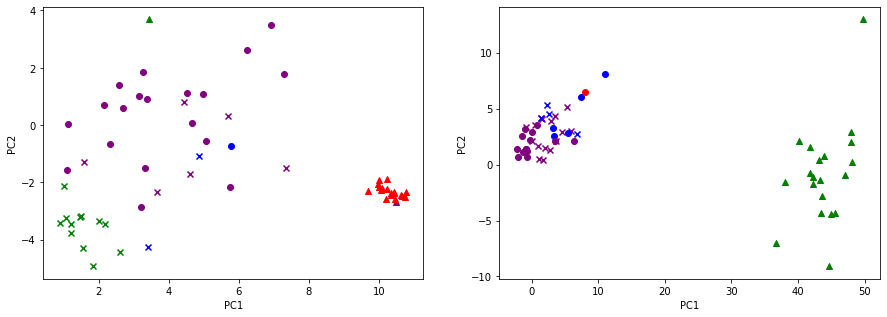

In [190]:
points = plot_species_pca(bests[((bests["evolver"] == "ga") | (bests["evolver"] == "se-shape")) & (bests["controller"] == "homogeneous") & (bests["morphology"] == "direct")],
                          everybody[((everybody["evolver"] == "ga") | (everybody["evolver"] == "se-shape")) & (everybody["controller"] == "homogeneous") & (everybody["morphology"] == "direct")])

In [195]:
for (t, label, terrain), traj in points.groupby(["type", "label", "terrain"]):
    traj.to_csv("_".join(["rq3", t, terrain, shape_dict[label] if t == "shape" else behavior_dict[label]]) + ".txt",
               sep=" ", index=False)

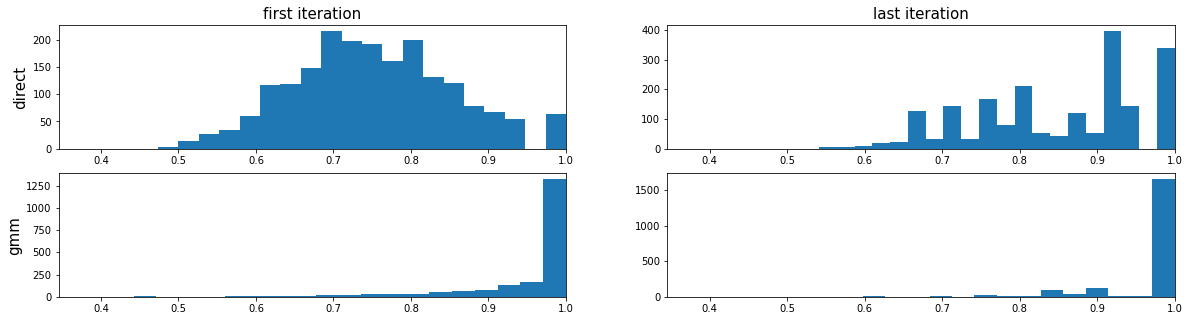

In [205]:
out = plot_feature_hist_by_morphology(everybody[((everybody["evolver"] == "ga") | (everybody["evolver"] == "se-shape")) & (everybody["controller"] == "homogeneous") & (everybody["terrain"] == "flat")], column="eccentricity", title="")    

In [206]:
out.to_csv("rq1_morphology_compactness_histogram.txt", sep=" ", index=False)